In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 資料前處理

### Transform 設定
- Training 用的 train_transform 加入比較多 data augmentation，以提升模型的泛化能力、避免 overfitting，提升魯棒性
- Validation 跟 testing 用的 test_transform 只做 Resize 跟 Normalize

In [ ]:
data_dir = '/mnt/sda1/shuof/DL/HW2/capsule'

# 相較上次作業，這次異常樣本本來就不多，再使用資料增強容易把特徵遮掉，所以都刪掉了
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.2),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.05),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#### 資料切分
- 使用 `train_test_split` 將資料集以 8:2 比例切分為 training set 跟 validation set。
- 使用 `stratify` 確保各類別在 training 跟 validation set 中的比例分佈一致。

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class FilenameLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.labels = []
        self.transform = transform

        # 建立類別名到索引的對應（sorted 確保順序一致）
        self.class_to_idx = {
            class_name: idx for idx, class_name in enumerate(sorted(os.listdir(root_dir)))
            if os.path.isdir(os.path.join(root_dir, class_name))
        }

        # 遍歷每個資料夾
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.img_paths.append(os.path.join(class_dir, fname))
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [5]:
full_dataset = FilenameLabelDataset('/mnt/sda1/shuof/DL/HW2/capsule')

indices = list(range(len(full_dataset)))
train_idx, valid_idx = train_test_split(
    indices, test_size=0.2, stratify=full_dataset.labels, random_state=42
)

class SubsetWithTransform(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.dataset[self.indices[i]]
        if self.transform:
            img = self.transform(img)
        return img, label

### DataLoader 設定

In [6]:
batch_size = 32

train_dataset = SubsetWithTransform(full_dataset, train_idx, train_transform)
valid_dataset = SubsetWithTransform(full_dataset, valid_idx, test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

### 確認標籤正確

In [7]:
from collections import defaultdict, Counter
import os

train_labels = [train_dataset.dataset[i][1] for i in train_idx]
valid_labels = [valid_dataset.dataset[i][1] for i in valid_idx]

print("Train:", Counter(train_labels))
print("Valid:", Counter(valid_labels))

Train: Counter({2: 175, 4: 18, 1: 18, 0: 18, 3: 17, 5: 16})
Valid: Counter({2: 44, 0: 5, 4: 5, 3: 4, 5: 4, 1: 4})


In [ ]:
folder_label_map = defaultdict(list)

for path, label in zip(full_dataset.img_paths, full_dataset.labels):
    folder_name = os.path.basename(os.path.dirname(path))  
    folder_label_map[folder_name].append(label)

total_counter = Counter()

for folder in sorted(folder_label_map.keys()):
    label_counts = Counter(folder_label_map[folder])
    print(f"{folder}: {label_counts}")
    total_counter.update(label_counts)

num_classes = 6
class_counts = np.array([total_counter[i] for i in range(num_classes)])
print("class_counts:", class_counts)

crack: Counter({0: 23})
faulty_imprint: Counter({1: 22})
good: Counter({2: 219})
poke: Counter({3: 21})
scratch: Counter({4: 23})
squeeze: Counter({5: 20})
class_counts: [ 23  22 219  21  23  20]


## 查看 batch 內容

In [9]:
def inverse_normalize(img_norm, mean, std):

    # Convert mean and std to tensors with the right shape for broadcasting
    mean = torch.tensor(mean, device=img_norm.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=img_norm.device).view(1, -1, 1, 1)

    # (x-mean)/std = img
    # x = img*std + mean
    # Apply inverse normalization
    return img_norm * std + mean

def imshow(img):
    # img = inverse_normalize(img, mean, std)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([32, 3, 224, 224])


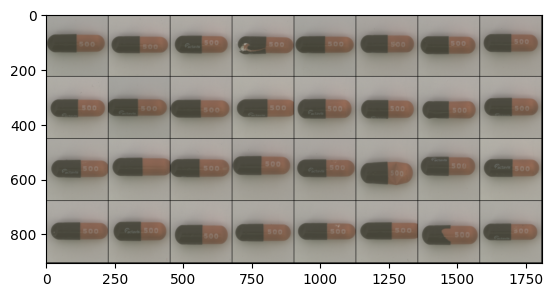

In [10]:
from torchvision.utils import make_grid

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)

mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
image_grid = make_grid(inverse_normalize(images, mean, std))

imshow(image_grid)

# 自建的ResNet

## 模型設計

In [11]:
# 設定
best_acc = 0
patience = 50
counter = 0
best_model_path = 'best_model.pt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wwight
beta = 0.999

In [12]:
def compute_dynamic_weights(class_counts, beta=0.999):
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float).to(device)

In [13]:
# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

# ResNet Bottleneck Block with SE
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.se = SEBlock(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ResNet50 with SE blocks
class ResNet50SE(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ResNet50SE, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 配置：ResNet50 = [3, 4, 6, 3]
        self.layer1 = self._make_layer(Bottleneck, 64,  3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(512 * Bottleneck.expansion, 256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256, num_classes)
                )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        #x = self.dropout(x)
        x = self.fc(x)
        return x

In [14]:
def compute_dynamic_loss_weights(class_val_losses, class_val_counts, class_counts, alpha=0.5, num_classes=num_classes):
    eps = 1e-6
    avg_val_losses = np.array([
        class_val_losses[c] / class_val_counts[c] if class_val_counts[c] > 0 else 0.0
        for c in range(num_classes)
    ])

    loss_weights = avg_val_losses / (np.sum(avg_val_losses) + eps)
    count_weights = 1.0 / (class_counts + eps)
    count_weights = count_weights / np.sum(count_weights)

    final_weights = alpha * loss_weights + (1 - alpha) * count_weights
    final_weights = final_weights / np.sum(final_weights) * num_classes

    return torch.tensor(final_weights, dtype=torch.float)

alpha = 0.5

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # class weights，Tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = softmax prob of the correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss  # (for per-sample loss)

## 模型訓練與預測

其他測試過效果沒那麼好的

#criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
#optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [16]:
# from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

best_acc = 0
Epochs = 300

# 儲存訓練過程的數據
train_losses = []
train_accuracies = []
val_accuracies = []

model = ResNet50SE(num_classes=num_classes).to(device)
model = model.to(device)

weights = compute_dynamic_weights(class_counts)

# ----- Loss, Optimizer, Scheduler -----
criterion = FocalLoss(alpha=weights, gamma=2.0, reduction='none')  # 可配合你 per-sample loss 架構
#criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1, reduction='none')  # ⭐ 重點：per-sample loss
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
#scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)


# ----- 開始訓練 -----
for epoch in range(Epochs):
    model.train()
    
    total_loss = 0
    correct_train, total_train = 0, 0
    class_loss_sum = defaultdict(float)
    class_sample_count = defaultdict(int)

    train_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        per_sample_loss = criterion(outputs, labels)
        loss = per_sample_loss.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_loss_sum[label] += per_sample_loss[i].item()
            class_sample_count[label] += 1

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"\nEpoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")
    
    # ----- 驗證 -----
    model.eval()
    correct, total = 0, 0
    class_val_losses = [0.0 for _ in range(num_classes)]
    class_val_counts = [0 for _ in range(num_classes)]

    val_bar = tqdm(valid_loader, desc=f"[Valid] Epoch {epoch+1}", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss = F.cross_entropy(outputs, labels, reduction='none')

            for i in range(len(labels)):
                cls = labels[i].item()
                class_val_losses[cls] += val_loss[i].item()
                class_val_counts[cls] += 1

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")

    # 每10 epoch 顯示類別 loss 和動態調整 class weiights
    if epoch % 10 == 0:
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
        print("[Per-class Training Loss]")
        for c in range(num_classes):
            if class_sample_count[c] > 0:
                avg = class_loss_sum[c] / class_sample_count[c]
                print(f"  Class {c}: Avg Train Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        print("[Per-class Validation Loss]")
        for c in range(num_classes):
            if class_val_counts[c] > 0:
                avg = class_val_losses[c] / class_val_counts[c]
                print(f"  Class {c}: Avg Val Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        # 動態調整 class weights（方式B）
        weights = compute_dynamic_loss_weights(class_val_losses, class_val_counts, class_counts, alpha=0.5).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1, reduction='none')
        print(f"Updated class weights at epoch {epoch+1}: {weights.cpu().numpy()}")

    # Early stopping 判斷
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("=== Accuracy improved, model saved. ===")
    else:
        counter += 1
        print(f"=== No improvement for {counter} epochs. ===")

    if counter >= patience:
        print("=== Early stopping triggered. ===")
        break

    scheduler.step()


Epoch 1 | Training Loss: 0.5689


Training Accuracy: 0.0763 | Validation Accuracy: 0.0909
Current LR: 0.000300
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.1477
  Class 1: Avg Train Loss = 1.8779
  Class 2: Avg Train Loss = 0.0279
  Class 3: Avg Train Loss = 1.5425
  Class 4: Avg Train Loss = 2.2640
  Class 5: Avg Train Loss = 1.7772
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.9144
  Class 1: Avg Val Loss = 1.6199
  Class 2: Avg Val Loss = 2.1704
  Class 3: Avg Val Loss = 1.7754
  Class 4: Avg Val Loss = 1.6202
  Class 5: Avg Val Loss = 1.7533
Updated class weights at epoch 1: [1.0851458  1.029031   0.65830904 1.0996796  1.0038258  1.1240088 ]
=== Accuracy improved, model saved. ===



Epoch 2 | Training Loss: 1.5093


Training Accuracy: 0.3282 | Validation Accuracy: 0.6667
=== Accuracy improved, model saved. ===



Epoch 3 | Training Loss: 1.2998


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 1 epochs. ===



Epoch 4 | Training Loss: 1.1924


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 2 epochs. ===



Epoch 5 | Training Loss: 1.2444


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 3 epochs. ===



Epoch 6 | Training Loss: 1.2097


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 4 epochs. ===



Epoch 7 | Training Loss: 1.2068


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 5 epochs. ===



Epoch 8 | Training Loss: 1.2172


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 6 epochs. ===



Epoch 9 | Training Loss: 1.2831


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 7 epochs. ===



Epoch 10 | Training Loss: 1.2426


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 8 epochs. ===



Epoch 11 | Training Loss: 1.2460


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
Current LR: 0.000300
[Per-class Training Loss]
  Class 0: Avg Train Loss = 2.1730
  Class 1: Avg Train Loss = 2.3248
  Class 2: Avg Train Loss = 0.6512
  Class 3: Avg Train Loss = 2.5144
  Class 4: Avg Train Loss = 2.3651
  Class 5: Avg Train Loss = 2.6265
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.9840
  Class 1: Avg Val Loss = 2.2118
  Class 2: Avg Val Loss = 0.7169
  Class 3: Avg Val Loss = 2.2999
  Class 4: Avg Val Loss = 2.0497
  Class 5: Avg Val Loss = 2.3568
Updated class weights at epoch 11: [1.0682687 1.1523486 0.2434822 1.202768  1.0852295 1.2479031]
=== No improvement for 9 epochs. ===



Epoch 12 | Training Loss: 1.0360


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 10 epochs. ===



Epoch 13 | Training Loss: 1.0012


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 11 epochs. ===



Epoch 14 | Training Loss: 1.0194


Training Accuracy: 0.6260 | Validation Accuracy: 0.6212
=== No improvement for 12 epochs. ===



Epoch 15 | Training Loss: 1.0080


Training Accuracy: 0.6336 | Validation Accuracy: 0.6667
=== No improvement for 13 epochs. ===



Epoch 16 | Training Loss: 1.0208


Training Accuracy: 0.6336 | Validation Accuracy: 0.6667
=== No improvement for 14 epochs. ===



Epoch 17 | Training Loss: 1.0207


Training Accuracy: 0.5992 | Validation Accuracy: 0.6667
=== No improvement for 15 epochs. ===



Epoch 18 | Training Loss: 0.9510


Training Accuracy: 0.6145 | Validation Accuracy: 0.6667
=== No improvement for 16 epochs. ===



Epoch 19 | Training Loss: 0.9438


Training Accuracy: 0.5840 | Validation Accuracy: 0.6212
=== No improvement for 17 epochs. ===



Epoch 20 | Training Loss: 0.9201


Training Accuracy: 0.5992 | Validation Accuracy: 0.5455
=== No improvement for 18 epochs. ===



Epoch 21 | Training Loss: 0.9167


Training Accuracy: 0.5916 | Validation Accuracy: 0.5606
Current LR: 0.000150
[Per-class Training Loss]
  Class 0: Avg Train Loss = 2.1106
  Class 1: Avg Train Loss = 1.9753
  Class 2: Avg Train Loss = 0.4435
  Class 3: Avg Train Loss = 2.0578
  Class 4: Avg Train Loss = 1.7797
  Class 5: Avg Train Loss = 2.1212
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.8638
  Class 1: Avg Val Loss = 1.7562
  Class 2: Avg Val Loss = 1.3476
  Class 3: Avg Val Loss = 1.6794
  Class 4: Avg Val Loss = 1.6091
  Class 5: Avg Val Loss = 1.6987
Updated class weights at epoch 21: [1.1176808 1.1105145 0.4644978 1.1150686 1.0409282 1.1513101]
=== No improvement for 19 epochs. ===



Epoch 22 | Training Loss: 0.9897


Training Accuracy: 0.6260 | Validation Accuracy: 0.6667
=== No improvement for 20 epochs. ===



Epoch 23 | Training Loss: 1.0070


Training Accuracy: 0.6870 | Validation Accuracy: 0.4848
=== No improvement for 21 epochs. ===



Epoch 24 | Training Loss: 1.0484


Training Accuracy: 0.6412 | Validation Accuracy: 0.6515
=== No improvement for 22 epochs. ===



Epoch 25 | Training Loss: 0.9953


Training Accuracy: 0.6412 | Validation Accuracy: 0.6515
=== No improvement for 23 epochs. ===



Epoch 26 | Training Loss: 0.9900


Training Accuracy: 0.6870 | Validation Accuracy: 0.6364
=== No improvement for 24 epochs. ===



Epoch 27 | Training Loss: 0.9930


Training Accuracy: 0.6908 | Validation Accuracy: 0.6212
=== No improvement for 25 epochs. ===



Epoch 28 | Training Loss: 0.9307


Training Accuracy: 0.6679 | Validation Accuracy: 0.6818
=== Accuracy improved, model saved. ===



Epoch 29 | Training Loss: 0.9586


Training Accuracy: 0.6794 | Validation Accuracy: 0.6364
=== No improvement for 1 epochs. ===



Epoch 30 | Training Loss: 0.9509


Training Accuracy: 0.6908 | Validation Accuracy: 0.6970
=== Accuracy improved, model saved. ===



Epoch 31 | Training Loss: 0.9817


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
Current LR: 0.000300
[Per-class Training Loss]
  Class 0: Avg Train Loss = 2.0023
  Class 1: Avg Train Loss = 1.9768
  Class 2: Avg Train Loss = 0.4970
  Class 3: Avg Train Loss = 2.1124
  Class 4: Avg Train Loss = 1.7913
  Class 5: Avg Train Loss = 1.9581
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 3.6880
  Class 1: Avg Val Loss = 3.4098
  Class 2: Avg Val Loss = 0.1064
  Class 3: Avg Val Loss = 3.3588
  Class 4: Avg Val Loss = 2.9082
  Class 5: Avg Val Loss = 3.4203
Updated class weights at epoch 31: [1.211004   1.18686    0.07729685 1.2054864  1.0725033  1.2468494 ]
=== No improvement for 1 epochs. ===



Epoch 32 | Training Loss: 0.9466


Training Accuracy: 0.6336 | Validation Accuracy: 0.6667
=== No improvement for 2 epochs. ===



Epoch 33 | Training Loss: 0.8236


Training Accuracy: 0.2786 | Validation Accuracy: 0.0606
=== No improvement for 3 epochs. ===



Epoch 34 | Training Loss: 0.9106


Training Accuracy: 0.0916 | Validation Accuracy: 0.0606
=== No improvement for 4 epochs. ===



Epoch 35 | Training Loss: 0.8853


Training Accuracy: 0.0687 | Validation Accuracy: 0.0909
=== No improvement for 5 epochs. ===



Epoch 36 | Training Loss: 0.9057


Training Accuracy: 0.1107 | Validation Accuracy: 0.0758
=== No improvement for 6 epochs. ===



Epoch 37 | Training Loss: 0.9271


Training Accuracy: 0.0878 | Validation Accuracy: 0.0606
=== No improvement for 7 epochs. ===



Epoch 38 | Training Loss: 0.8450


Training Accuracy: 0.1221 | Validation Accuracy: 0.3333
=== No improvement for 8 epochs. ===



Epoch 39 | Training Loss: 0.8353


Training Accuracy: 0.1603 | Validation Accuracy: 0.3030
=== No improvement for 9 epochs. ===



Epoch 40 | Training Loss: 0.8383


Training Accuracy: 0.2328 | Validation Accuracy: 0.1061
=== No improvement for 10 epochs. ===



Epoch 41 | Training Loss: 0.8678


Training Accuracy: 0.1908 | Validation Accuracy: 0.0606
Current LR: 0.000256
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.7507
  Class 1: Avg Train Loss = 2.0212
  Class 2: Avg Train Loss = 0.3193
  Class 3: Avg Train Loss = 2.0163
  Class 4: Avg Train Loss = 1.7064
  Class 5: Avg Train Loss = 1.9982
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.6361
  Class 1: Avg Val Loss = 1.8283
  Class 2: Avg Val Loss = 1.9628
  Class 3: Avg Val Loss = 1.5992
  Class 4: Avg Val Loss = 1.5978
  Class 5: Avg Val Loss = 1.4880
Updated class weights at epoch 41: [1.0413659 1.1236581 0.6407005 1.0833929 1.0300275 1.0808554]
=== No improvement for 11 epochs. ===



Epoch 42 | Training Loss: 1.2636


Training Accuracy: 0.4313 | Validation Accuracy: 0.0758
=== No improvement for 12 epochs. ===



Epoch 43 | Training Loss: 1.0331


Training Accuracy: 0.6985 | Validation Accuracy: 0.6364
=== No improvement for 13 epochs. ===



Epoch 44 | Training Loss: 1.0353


Training Accuracy: 0.6947 | Validation Accuracy: 0.0606
=== No improvement for 14 epochs. ===



Epoch 45 | Training Loss: 1.0398


Training Accuracy: 0.6794 | Validation Accuracy: 0.4545
=== No improvement for 15 epochs. ===



Epoch 46 | Training Loss: 1.0126


Training Accuracy: 0.6985 | Validation Accuracy: 0.6212
=== No improvement for 16 epochs. ===



Epoch 47 | Training Loss: 0.9491


Training Accuracy: 0.7290 | Validation Accuracy: 0.6667
=== No improvement for 17 epochs. ===



Epoch 48 | Training Loss: 0.9914


Training Accuracy: 0.7176 | Validation Accuracy: 0.6667
=== No improvement for 18 epochs. ===



Epoch 49 | Training Loss: 1.1550


Training Accuracy: 0.6870 | Validation Accuracy: 0.3788
=== No improvement for 19 epochs. ===



Epoch 50 | Training Loss: 1.0097


Training Accuracy: 0.6908 | Validation Accuracy: 0.6667
=== No improvement for 20 epochs. ===



Epoch 51 | Training Loss: 1.0088


Training Accuracy: 0.6908 | Validation Accuracy: 0.6515
Current LR: 0.000150
[Per-class Training Loss]
  Class 0: Avg Train Loss = 2.0393
  Class 1: Avg Train Loss = 2.0108
  Class 2: Avg Train Loss = 0.5660
  Class 3: Avg Train Loss = 2.0012
  Class 4: Avg Train Loss = 1.5854
  Class 5: Avg Train Loss = 1.7187
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.3328
  Class 1: Avg Val Loss = 1.7373
  Class 2: Avg Val Loss = 0.6068
  Class 3: Avg Val Loss = 1.9930
  Class 4: Avg Val Loss = 1.3903
  Class 5: Avg Val Loss = 1.6693
Updated class weights at epoch 51: [1.2752953  1.1169479  0.24548809 1.2234656  0.98468    1.1541231 ]
=== No improvement for 21 epochs. ===



Epoch 52 | Training Loss: 0.9188


Training Accuracy: 0.6870 | Validation Accuracy: 0.3788
=== No improvement for 22 epochs. ===



Epoch 53 | Training Loss: 0.9149


Training Accuracy: 0.7023 | Validation Accuracy: 0.3030
=== No improvement for 23 epochs. ===



Epoch 54 | Training Loss: 0.8883


Training Accuracy: 0.6908 | Validation Accuracy: 0.1667
=== No improvement for 24 epochs. ===



Epoch 55 | Training Loss: 0.9025


Training Accuracy: 0.6336 | Validation Accuracy: 0.2273
=== No improvement for 25 epochs. ===



Epoch 56 | Training Loss: 0.8878


Training Accuracy: 0.6832 | Validation Accuracy: 0.5000
=== No improvement for 26 epochs. ===



Epoch 57 | Training Loss: 0.8676


Training Accuracy: 0.7099 | Validation Accuracy: 0.6667
=== No improvement for 27 epochs. ===



Epoch 58 | Training Loss: 0.8901


Training Accuracy: 0.6908 | Validation Accuracy: 0.6818
=== No improvement for 28 epochs. ===



Epoch 59 | Training Loss: 0.9095


Training Accuracy: 0.6908 | Validation Accuracy: 0.4091
=== No improvement for 29 epochs. ===



Epoch 60 | Training Loss: 0.9039


Training Accuracy: 0.6947 | Validation Accuracy: 0.6364
=== No improvement for 30 epochs. ===



Epoch 61 | Training Loss: 0.8367


Training Accuracy: 0.6794 | Validation Accuracy: 0.6667
Current LR: 0.000045
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.6319
  Class 1: Avg Train Loss = 1.8437
  Class 2: Avg Train Loss = 0.4181
  Class 3: Avg Train Loss = 2.0918
  Class 4: Avg Train Loss = 1.5617
  Class 5: Avg Train Loss = 1.4043
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.9990
  Class 1: Avg Val Loss = 1.7828
  Class 2: Avg Val Loss = 0.4555
  Class 3: Avg Val Loss = 1.9349
  Class 4: Avg Val Loss = 2.2486
  Class 5: Avg Val Loss = 1.8950
Updated class weights at epoch 61: [1.1373404  1.0997415  0.19086753 1.1716307  1.2099326  1.1904873 ]
=== No improvement for 31 epochs. ===



Epoch 62 | Training Loss: 0.8792


Training Accuracy: 0.6412 | Validation Accuracy: 0.6818
=== No improvement for 32 epochs. ===



Epoch 63 | Training Loss: 0.8486


Training Accuracy: 0.7176 | Validation Accuracy: 0.6818
=== No improvement for 33 epochs. ===



Epoch 64 | Training Loss: 0.8660


Training Accuracy: 0.6870 | Validation Accuracy: 0.4848
=== No improvement for 34 epochs. ===



Epoch 65 | Training Loss: 0.7881


Training Accuracy: 0.6832 | Validation Accuracy: 0.3182
=== No improvement for 35 epochs. ===



Epoch 66 | Training Loss: 0.8042


Training Accuracy: 0.7023 | Validation Accuracy: 0.5758
=== No improvement for 36 epochs. ===



Epoch 67 | Training Loss: 0.8159


Training Accuracy: 0.6679 | Validation Accuracy: 0.6970
=== No improvement for 37 epochs. ===



Epoch 68 | Training Loss: 0.7908


Training Accuracy: 0.6756 | Validation Accuracy: 0.7121
=== Accuracy improved, model saved. ===



Epoch 69 | Training Loss: 0.7916


Training Accuracy: 0.7366 | Validation Accuracy: 0.6970
=== No improvement for 1 epochs. ===



Epoch 70 | Training Loss: 0.8301


Training Accuracy: 0.6985 | Validation Accuracy: 0.6970
=== No improvement for 2 epochs. ===



Epoch 71 | Training Loss: 0.9093


Training Accuracy: 0.6489 | Validation Accuracy: 0.2879
Current LR: 0.000300
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.9761
  Class 1: Avg Train Loss = 1.7429
  Class 2: Avg Train Loss = 0.3886
  Class 3: Avg Train Loss = 2.0622
  Class 4: Avg Train Loss = 1.7690
  Class 5: Avg Train Loss = 1.9476
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 0.6901
  Class 1: Avg Val Loss = 2.0032
  Class 2: Avg Val Loss = 1.6545
  Class 3: Avg Val Loss = 1.9851
  Class 4: Avg Val Loss = 2.5131
  Class 5: Avg Val Loss = 4.2325
Updated class weights at epoch 71: [0.7142834  1.040779   0.43790564 1.0643076  1.1324699  1.6102545 ]
=== No improvement for 3 epochs. ===



Epoch 72 | Training Loss: 0.9423


Training Accuracy: 0.6832 | Validation Accuracy: 0.6667
=== No improvement for 4 epochs. ===



Epoch 73 | Training Loss: 0.9497


Training Accuracy: 0.7137 | Validation Accuracy: 0.6667
=== No improvement for 5 epochs. ===



Epoch 74 | Training Loss: 0.9148


Training Accuracy: 0.6794 | Validation Accuracy: 0.1061
=== No improvement for 6 epochs. ===



Epoch 75 | Training Loss: 0.8633


Training Accuracy: 0.7366 | Validation Accuracy: 0.1061
=== No improvement for 7 epochs. ===



Epoch 76 | Training Loss: 0.9199


Training Accuracy: 0.7176 | Validation Accuracy: 0.4697
=== No improvement for 8 epochs. ===



Epoch 77 | Training Loss: 0.9450


Training Accuracy: 0.7176 | Validation Accuracy: 0.3485
=== No improvement for 9 epochs. ===



Epoch 78 | Training Loss: 0.8729


Training Accuracy: 0.7176 | Validation Accuracy: 0.6364
=== No improvement for 10 epochs. ===



Epoch 79 | Training Loss: 0.9392


Training Accuracy: 0.7176 | Validation Accuracy: 0.6667
=== No improvement for 11 epochs. ===



Epoch 80 | Training Loss: 0.9211


Training Accuracy: 0.6908 | Validation Accuracy: 0.3182
=== No improvement for 12 epochs. ===



Epoch 81 | Training Loss: 0.9297


Training Accuracy: 0.6947 | Validation Accuracy: 0.6667
Current LR: 0.000289
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.6699
  Class 1: Avg Train Loss = 1.7976
  Class 2: Avg Train Loss = 0.5071
  Class 3: Avg Train Loss = 2.0331
  Class 4: Avg Train Loss = 1.5475
  Class 5: Avg Train Loss = 1.4870
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 3.7112
  Class 1: Avg Val Loss = 4.2552
  Class 2: Avg Val Loss = 0.0643
  Class 3: Avg Val Loss = 3.9780
  Class 4: Avg Val Loss = 3.8583
  Class 5: Avg Val Loss = 3.0685
Updated class weights at epoch 81: [1.1439706  1.2554361  0.06857669 1.2391864  1.1672819  1.1255484 ]
=== No improvement for 13 epochs. ===



Epoch 82 | Training Loss: 0.8362


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 14 epochs. ===



Epoch 83 | Training Loss: 0.7623


Training Accuracy: 0.5687 | Validation Accuracy: 0.0606
=== No improvement for 15 epochs. ===



Epoch 84 | Training Loss: 0.7705


Training Accuracy: 0.4389 | Validation Accuracy: 0.1061
=== No improvement for 16 epochs. ===



Epoch 85 | Training Loss: 0.8162


Training Accuracy: 0.4885 | Validation Accuracy: 0.2424
=== No improvement for 17 epochs. ===



Epoch 86 | Training Loss: 0.7495


Training Accuracy: 0.4275 | Validation Accuracy: 0.6818
=== No improvement for 18 epochs. ===



Epoch 87 | Training Loss: 0.7688


Training Accuracy: 0.5076 | Validation Accuracy: 0.0909
=== No improvement for 19 epochs. ===



Epoch 88 | Training Loss: 0.8178


Training Accuracy: 0.5420 | Validation Accuracy: 0.4848
=== No improvement for 20 epochs. ===



Epoch 89 | Training Loss: 0.7596


Training Accuracy: 0.5267 | Validation Accuracy: 0.6667
=== No improvement for 21 epochs. ===



Epoch 90 | Training Loss: 0.7847


Training Accuracy: 0.4885 | Validation Accuracy: 0.1364
=== No improvement for 22 epochs. ===



Epoch 91 | Training Loss: 0.7942


Training Accuracy: 0.5573 | Validation Accuracy: 0.0758
Current LR: 0.000256
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.4865
  Class 1: Avg Train Loss = 1.8461
  Class 2: Avg Train Loss = 0.2935
  Class 3: Avg Train Loss = 1.9224
  Class 4: Avg Train Loss = 1.7520
  Class 5: Avg Train Loss = 1.4068
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.3035
  Class 1: Avg Val Loss = 1.4019
  Class 2: Avg Val Loss = 7.8547
  Class 3: Avg Val Loss = 1.5419
  Class 4: Avg Val Loss = 1.8364
  Class 5: Avg Val Loss = 4.9137
Updated class weights at epoch 91: [0.76343006 0.80435663 1.3083375  0.85431623 0.8482281  1.4213315 ]
=== No improvement for 23 epochs. ===



Epoch 92 | Training Loss: 1.2362


Training Accuracy: 0.6832 | Validation Accuracy: 0.7121
=== No improvement for 24 epochs. ===



Epoch 93 | Training Loss: 1.1602


Training Accuracy: 0.7137 | Validation Accuracy: 0.5455
=== No improvement for 25 epochs. ===



Epoch 94 | Training Loss: 1.0908


Training Accuracy: 0.7214 | Validation Accuracy: 0.6515
=== No improvement for 26 epochs. ===



Epoch 95 | Training Loss: 0.9579


Training Accuracy: 0.7099 | Validation Accuracy: 0.0606
=== No improvement for 27 epochs. ===



Epoch 96 | Training Loss: 0.9482


Training Accuracy: 0.7137 | Validation Accuracy: 0.6667
=== No improvement for 28 epochs. ===



Epoch 97 | Training Loss: 0.9561


Training Accuracy: 0.7366 | Validation Accuracy: 0.0606
=== No improvement for 29 epochs. ===



Epoch 98 | Training Loss: 0.9797


Training Accuracy: 0.7023 | Validation Accuracy: 0.1515
=== No improvement for 30 epochs. ===



Epoch 99 | Training Loss: 0.9973


Training Accuracy: 0.7099 | Validation Accuracy: 0.2121
=== No improvement for 31 epochs. ===



Epoch 100 | Training Loss: 0.9162


Training Accuracy: 0.7595 | Validation Accuracy: 0.1061
=== No improvement for 32 epochs. ===



Epoch 101 | Training Loss: 0.9238


Training Accuracy: 0.7290 | Validation Accuracy: 0.2576
Current LR: 0.000208
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.5588
  Class 1: Avg Train Loss = 1.8064
  Class 2: Avg Train Loss = 0.5718
  Class 3: Avg Train Loss = 1.6704
  Class 4: Avg Train Loss = 1.4991
  Class 5: Avg Train Loss = 2.0882
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.6224
  Class 1: Avg Val Loss = 1.8773
  Class 2: Avg Val Loss = 2.2615
  Class 3: Avg Val Loss = 1.5272
  Class 4: Avg Val Loss = 1.7055
  Class 5: Avg Val Loss = 2.9970
Updated class weights at epoch 101: [0.9619077 1.0509437 0.6242039 0.9910342 0.9827044 1.389206 ]
=== No improvement for 33 epochs. ===



Epoch 102 | Training Loss: 0.9908


Training Accuracy: 0.7137 | Validation Accuracy: 0.6818
=== No improvement for 34 epochs. ===



Epoch 103 | Training Loss: 1.0958


Training Accuracy: 0.6985 | Validation Accuracy: 0.6667
=== No improvement for 35 epochs. ===



Epoch 104 | Training Loss: 1.0127


Training Accuracy: 0.7405 | Validation Accuracy: 0.6970
=== No improvement for 36 epochs. ===



Epoch 105 | Training Loss: 0.9408


Training Accuracy: 0.7443 | Validation Accuracy: 0.0909
=== No improvement for 37 epochs. ===



Epoch 106 | Training Loss: 0.9856


Training Accuracy: 0.7252 | Validation Accuracy: 0.6970
=== No improvement for 38 epochs. ===



Epoch 107 | Training Loss: 0.9307


Training Accuracy: 0.7023 | Validation Accuracy: 0.1515
=== No improvement for 39 epochs. ===



Epoch 108 | Training Loss: 0.8941


Training Accuracy: 0.7366 | Validation Accuracy: 0.6818
=== No improvement for 40 epochs. ===



Epoch 109 | Training Loss: 0.8907


Training Accuracy: 0.7824 | Validation Accuracy: 0.0758
=== No improvement for 41 epochs. ===



Epoch 110 | Training Loss: 0.9033


Training Accuracy: 0.7176 | Validation Accuracy: 0.0909
=== No improvement for 42 epochs. ===



Epoch 111 | Training Loss: 0.8475


Training Accuracy: 0.7519 | Validation Accuracy: 0.7424
Current LR: 0.000150
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.4695
  Class 1: Avg Train Loss = 1.9014
  Class 2: Avg Train Loss = 0.4841
  Class 3: Avg Train Loss = 1.8254
  Class 4: Avg Train Loss = 1.5901
  Class 5: Avg Train Loss = 1.4704
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.1420
  Class 1: Avg Val Loss = 2.2223
  Class 2: Avg Val Loss = 0.2189
  Class 3: Avg Val Loss = 2.5055
  Class 4: Avg Val Loss = 1.9742
  Class 5: Avg Val Loss = 1.6591
Updated class weights at epoch 111: [1.1553286  1.2030531  0.11965051 1.3099861  1.1083735  1.1036081 ]
=== Accuracy improved, model saved. ===



Epoch 112 | Training Loss: 0.8570


Training Accuracy: 0.7405 | Validation Accuracy: 0.6364
=== No improvement for 1 epochs. ===



Epoch 113 | Training Loss: 0.7879


Training Accuracy: 0.7023 | Validation Accuracy: 0.4242
=== No improvement for 2 epochs. ===



Epoch 114 | Training Loss: 0.7691


Training Accuracy: 0.7252 | Validation Accuracy: 0.6970
=== No improvement for 3 epochs. ===



Epoch 115 | Training Loss: 0.8406


Training Accuracy: 0.7099 | Validation Accuracy: 0.5909
=== No improvement for 4 epochs. ===



Epoch 116 | Training Loss: 0.7884


Training Accuracy: 0.6489 | Validation Accuracy: 0.4848
=== No improvement for 5 epochs. ===



Epoch 117 | Training Loss: 0.8002


Training Accuracy: 0.6260 | Validation Accuracy: 0.3636
=== No improvement for 6 epochs. ===



Epoch 118 | Training Loss: 0.8065


Training Accuracy: 0.6489 | Validation Accuracy: 0.1212
=== No improvement for 7 epochs. ===



Epoch 119 | Training Loss: 0.7346


Training Accuracy: 0.6603 | Validation Accuracy: 0.4697
=== No improvement for 8 epochs. ===



Epoch 120 | Training Loss: 0.8198


Training Accuracy: 0.6679 | Validation Accuracy: 0.7121
=== No improvement for 9 epochs. ===



Epoch 121 | Training Loss: 0.7518


Training Accuracy: 0.6718 | Validation Accuracy: 0.5909
Current LR: 0.000093
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.5038
  Class 1: Avg Train Loss = 1.7223
  Class 2: Avg Train Loss = 0.3345
  Class 3: Avg Train Loss = 1.9825
  Class 4: Avg Train Loss = 1.6390
  Class 5: Avg Train Loss = 1.3115
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.1815
  Class 1: Avg Val Loss = 2.0107
  Class 2: Avg Val Loss = 0.9538
  Class 3: Avg Val Loss = 1.8217
  Class 4: Avg Val Loss = 2.2062
  Class 5: Avg Val Loss = 1.4193
Updated class weights at epoch 121: [0.9254755  1.2100575  0.35666597 1.1786444  1.2459124  1.0832443 ]
=== No improvement for 10 epochs. ===



Epoch 122 | Training Loss: 0.9067


Training Accuracy: 0.7099 | Validation Accuracy: 0.2879
=== No improvement for 11 epochs. ===



Epoch 123 | Training Loss: 0.8469


Training Accuracy: 0.7290 | Validation Accuracy: 0.2576
=== No improvement for 12 epochs. ===



Epoch 124 | Training Loss: 0.7843


Training Accuracy: 0.7557 | Validation Accuracy: 0.2879
=== No improvement for 13 epochs. ===



Epoch 125 | Training Loss: 0.8849


Training Accuracy: 0.7443 | Validation Accuracy: 0.2879
=== No improvement for 14 epochs. ===



Epoch 126 | Training Loss: 0.8378


Training Accuracy: 0.7710 | Validation Accuracy: 0.2273
=== No improvement for 15 epochs. ===



Epoch 127 | Training Loss: 0.8150


Training Accuracy: 0.7634 | Validation Accuracy: 0.1818
=== No improvement for 16 epochs. ===



Epoch 128 | Training Loss: 0.8469


Training Accuracy: 0.7672 | Validation Accuracy: 0.3485
=== No improvement for 17 epochs. ===



Epoch 129 | Training Loss: 0.8224


Training Accuracy: 0.7786 | Validation Accuracy: 0.7273
=== No improvement for 18 epochs. ===



Epoch 130 | Training Loss: 0.8995


Training Accuracy: 0.7290 | Validation Accuracy: 0.3485
=== No improvement for 19 epochs. ===



Epoch 131 | Training Loss: 0.8481


Training Accuracy: 0.7405 | Validation Accuracy: 0.2273
Current LR: 0.000045
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.4712
  Class 1: Avg Train Loss = 1.7760
  Class 2: Avg Train Loss = 0.4544
  Class 3: Avg Train Loss = 2.0482
  Class 4: Avg Train Loss = 1.5822
  Class 5: Avg Train Loss = 1.2031
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 3.5239
  Class 1: Avg Val Loss = 2.5585
  Class 2: Avg Val Loss = 2.6978
  Class 3: Avg Val Loss = 3.3184
  Class 4: Avg Val Loss = 2.2166
  Class 5: Avg Val Loss = 0.1410
Updated class weights at epoch 131: [1.2872866 1.1122129 0.6182472 1.2975982 1.0159986 0.6686564]
=== No improvement for 20 epochs. ===



Epoch 132 | Training Loss: 0.9236


Training Accuracy: 0.7137 | Validation Accuracy: 0.6364
=== No improvement for 21 epochs. ===



Epoch 133 | Training Loss: 0.8523


Training Accuracy: 0.7748 | Validation Accuracy: 0.6970
=== No improvement for 22 epochs. ===



Epoch 134 | Training Loss: 0.8883


Training Accuracy: 0.7519 | Validation Accuracy: 0.6970
=== No improvement for 23 epochs. ===



Epoch 135 | Training Loss: 0.8222


Training Accuracy: 0.7977 | Validation Accuracy: 0.4394
=== No improvement for 24 epochs. ===



Epoch 136 | Training Loss: 0.8320


Training Accuracy: 0.7901 | Validation Accuracy: 0.3939
=== No improvement for 25 epochs. ===



Epoch 137 | Training Loss: 0.8643


Training Accuracy: 0.7557 | Validation Accuracy: 0.6212
=== No improvement for 26 epochs. ===



Epoch 138 | Training Loss: 0.8361


Training Accuracy: 0.8092 | Validation Accuracy: 0.7121
=== No improvement for 27 epochs. ===



Epoch 139 | Training Loss: 0.8068


Training Accuracy: 0.7863 | Validation Accuracy: 0.7121
=== No improvement for 28 epochs. ===



Epoch 140 | Training Loss: 0.8328


Training Accuracy: 0.7786 | Validation Accuracy: 0.6970
=== No improvement for 29 epochs. ===



Epoch 141 | Training Loss: 0.8181


Training Accuracy: 0.7863 | Validation Accuracy: 0.6818
Current LR: 0.000012
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.4081
  Class 1: Avg Train Loss = 1.7427
  Class 2: Avg Train Loss = 0.4723
  Class 3: Avg Train Loss = 1.9479
  Class 4: Avg Train Loss = 1.4772
  Class 5: Avg Train Loss = 0.9710
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.2506
  Class 1: Avg Val Loss = 1.4508
  Class 2: Avg Val Loss = 0.5555
  Class 3: Avg Val Loss = 1.8759
  Class 4: Avg Val Loss = 1.2805
  Class 5: Avg Val Loss = 1.0542
Updated class weights at epoch 141: [1.3533751  1.0952942  0.25520667 1.2735704  1.0096654  1.0128883 ]
=== No improvement for 30 epochs. ===



Epoch 142 | Training Loss: 0.8454


Training Accuracy: 0.7481 | Validation Accuracy: 0.6818
=== No improvement for 31 epochs. ===



Epoch 143 | Training Loss: 0.8366


Training Accuracy: 0.7710 | Validation Accuracy: 0.6212
=== No improvement for 32 epochs. ===



Epoch 144 | Training Loss: 0.8053


Training Accuracy: 0.7977 | Validation Accuracy: 0.6061
=== No improvement for 33 epochs. ===



Epoch 145 | Training Loss: 0.7983


Training Accuracy: 0.7634 | Validation Accuracy: 0.6818
=== No improvement for 34 epochs. ===



Epoch 146 | Training Loss: 0.7942


Training Accuracy: 0.7863 | Validation Accuracy: 0.6818
=== No improvement for 35 epochs. ===



Epoch 147 | Training Loss: 0.8252


Training Accuracy: 0.7863 | Validation Accuracy: 0.6818
=== No improvement for 36 epochs. ===



Epoch 148 | Training Loss: 0.7995


Training Accuracy: 0.7595 | Validation Accuracy: 0.6970
=== No improvement for 37 epochs. ===



Epoch 149 | Training Loss: 0.9089


Training Accuracy: 0.7710 | Validation Accuracy: 0.6818
=== No improvement for 38 epochs. ===



Epoch 150 | Training Loss: 0.7384


Training Accuracy: 0.8206 | Validation Accuracy: 0.7121
=== No improvement for 39 epochs. ===



Epoch 151 | Training Loss: 0.8693


Training Accuracy: 0.7748 | Validation Accuracy: 0.1364
Current LR: 0.000300
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.4854
  Class 1: Avg Train Loss = 1.7964
  Class 2: Avg Train Loss = 0.3959
  Class 3: Avg Train Loss = 1.8655
  Class 4: Avg Train Loss = 1.5374
  Class 5: Avg Train Loss = 1.4497
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 0.3199
  Class 1: Avg Val Loss = 0.8939
  Class 2: Avg Val Loss = 18.8631
  Class 3: Avg Val Loss = 2.4091
  Class 4: Avg Val Loss = 5.7841
  Class 5: Avg Val Loss = 15.2977
Updated class weights at epoch 151: [0.57802373 0.64281934 1.357273   0.774834   0.95428216 1.6927677 ]
=== No improvement for 40 epochs. ===



Epoch 152 | Training Loss: 1.0717


Training Accuracy: 0.7290 | Validation Accuracy: 0.1515
=== No improvement for 41 epochs. ===



Epoch 153 | Training Loss: 0.9422


Training Accuracy: 0.7366 | Validation Accuracy: 0.0758
=== No improvement for 42 epochs. ===



Epoch 154 | Training Loss: 1.0329


Training Accuracy: 0.6870 | Validation Accuracy: 0.0606
=== No improvement for 43 epochs. ===



Epoch 155 | Training Loss: 0.9900


Training Accuracy: 0.6985 | Validation Accuracy: 0.0909
=== No improvement for 44 epochs. ===



Epoch 156 | Training Loss: 1.0093


Training Accuracy: 0.7023 | Validation Accuracy: 0.4545
=== No improvement for 45 epochs. ===



Epoch 157 | Training Loss: 0.8767


Training Accuracy: 0.7176 | Validation Accuracy: 0.6818
=== No improvement for 46 epochs. ===



Epoch 158 | Training Loss: 0.8451


Training Accuracy: 0.7366 | Validation Accuracy: 0.0909
=== No improvement for 47 epochs. ===



Epoch 159 | Training Loss: 0.8813


Training Accuracy: 0.7252 | Validation Accuracy: 0.6667
=== No improvement for 48 epochs. ===



Epoch 160 | Training Loss: 0.8269


Training Accuracy: 0.7328 | Validation Accuracy: 0.4242
=== No improvement for 49 epochs. ===



Epoch 161 | Training Loss: 0.9294


Training Accuracy: 0.7214 | Validation Accuracy: 0.1364
Current LR: 0.000297
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.6026
  Class 1: Avg Train Loss = 1.7308
  Class 2: Avg Train Loss = 0.5292
  Class 3: Avg Train Loss = 1.8925
  Class 4: Avg Train Loss = 1.6591
  Class 5: Avg Train Loss = 1.7770
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 8.8561
  Class 1: Avg Val Loss = 10.8188
  Class 2: Avg Val Loss = 4.6029
  Class 3: Avg Val Loss = 9.0033
  Class 4: Avg Val Loss = 6.8268
  Class 5: Avg Val Loss = 0.0050
Updated class weights at epoch 161: [1.2183323  1.3903947  0.40264177 1.282296   1.0665685  0.6397668 ]
=== No improvement for 50 epochs. ===
=== Early stopping triggered. ===


In [17]:
model

ResNet50SE(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(256, 1

### 模型訓練過程與變化(Training Loss跟 Validation Accuracy的變化圖)

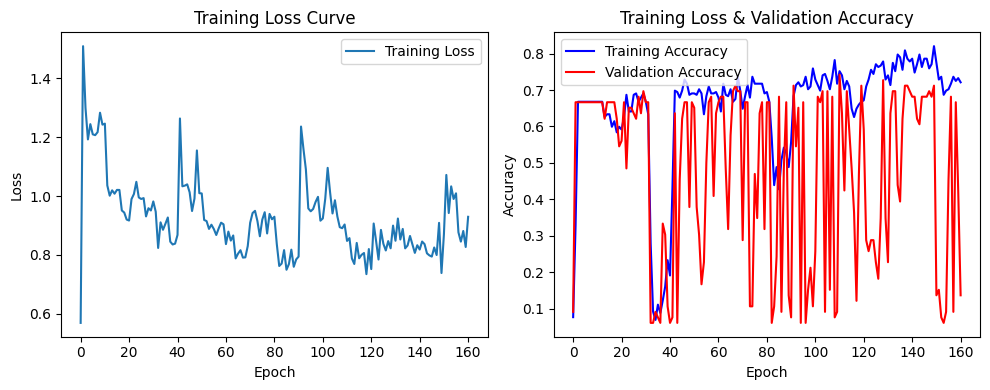

In [18]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
print(f"Self Beilt RestNet Acc = {best_acc:.4f}")

Self Beilt RestNet Acc = 0.7424


## 其他檢查內容

### 測試單張圖片預測結果

預測 → 類別：5



/tmp/ipykernel_2757843/2732135582.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


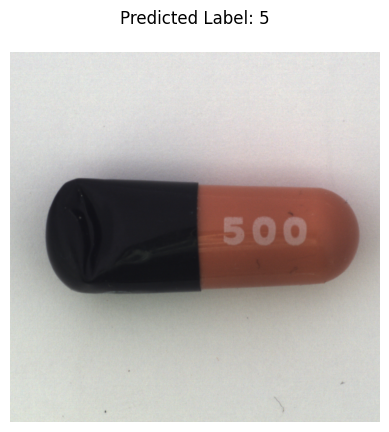

In [43]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/mnt/sda1/shuof/DL/HW2/capsule/squeeze/011.png').convert('RGB')
img_tensor = test_transform(img).unsqueeze(0).to(device)

model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    pred = model(img_tensor).argmax(1).item()
print(f"預測 → 類別：{pred}\n")

plt.imshow(img)
plt.title(f"Predicted Label: {pred}\n")
plt.axis('off')
plt.show()

### 查看 Layer 資訊

In [31]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ---------- 要視覺化的層 ----------
feature_maps = {}

def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

# ---------- 註冊 hook ----------
def register_hooks(model):
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.layer1[0].register_forward_hook(get_activation('layer1_block0'))
    model.layer2[0].register_forward_hook(get_activation('layer2_block0'))
    model.layer3[0].register_forward_hook(get_activation('layer3_block0'))
    model.layer4[0].register_forward_hook(get_activation('layer4_block0'))

# ---------- 特徵圖畫圖工具 ----------
def visualize_feature_map(layer_name, num_channels=6):
    fmap = feature_maps[layer_name][0]  # shape: [C, H, W]
    num_channels = min(fmap.shape[0], num_channels)

    plt.figure(figsize=(15, 5))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(fmap[i], cmap='viridis')
        plt.title(f"{layer_name} - ch{i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------- 單張圖片推論 ----------
def infer_and_visualize(img_path, model):
    # 相同 test transform（你也可以調整）
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        _ = model(input_tensor)

    visualize_feature_map('conv1')
    visualize_feature_map('layer1_block0')
    visualize_feature_map('layer3_block0')
    visualize_feature_map('layer4_block0')

/tmp/ipykernel_2757843/1777499033.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


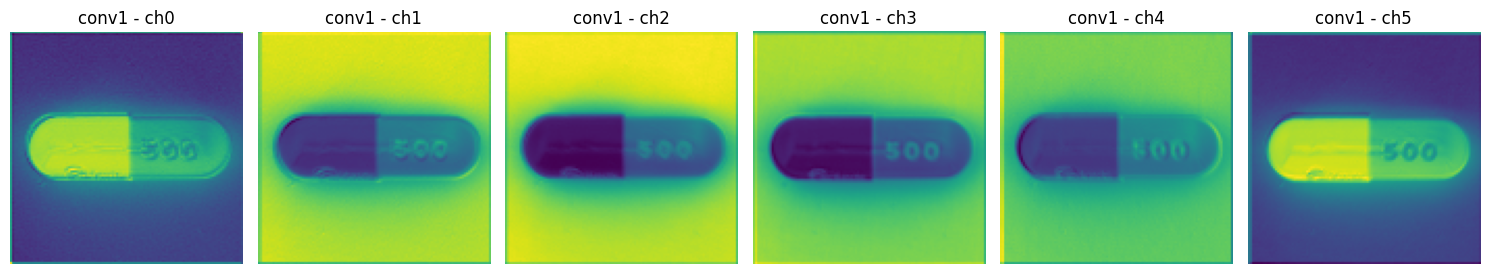

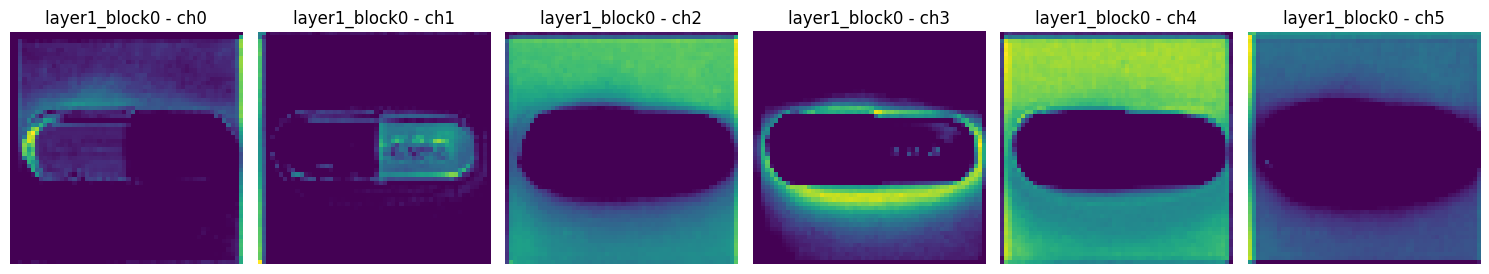

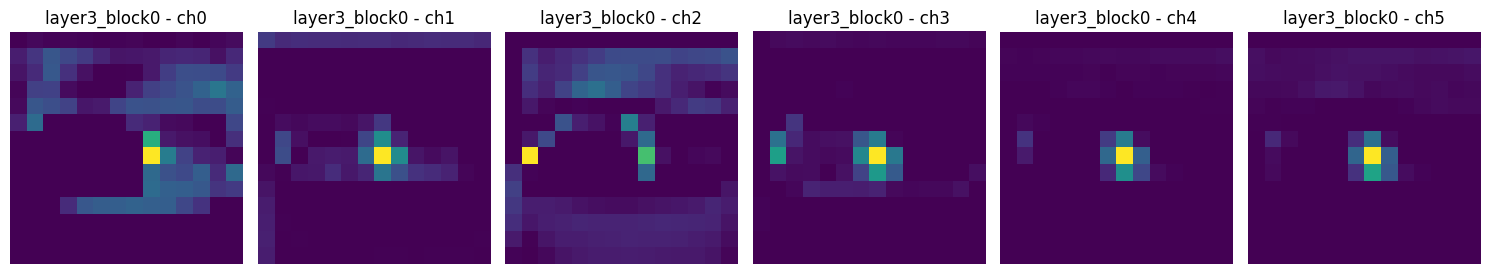

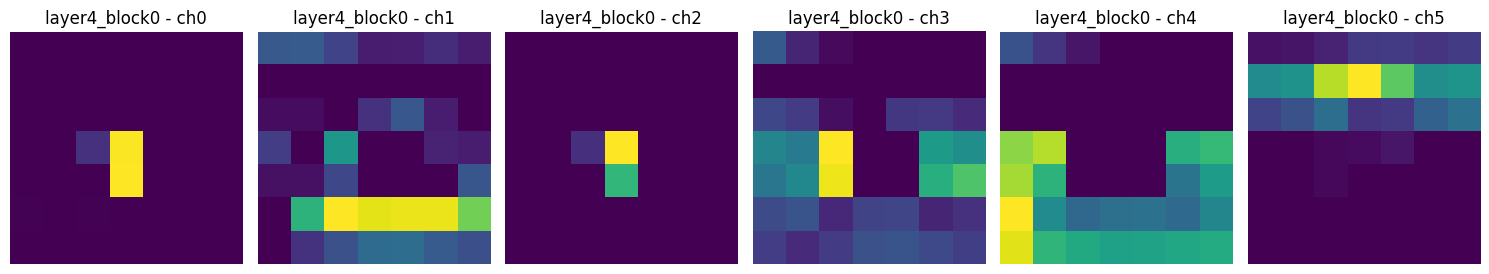

In [44]:
# 1. 訓練完的模型
model = ResNet50SE(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('best_model.pt'))
register_hooks(model)

# 2. 指定一張圖路徑
img_path = '/mnt/sda1/shuof/DL/HW2/capsule/scratch/000.png'
infer_and_visualize(img_path, model)

# Pre-Trained 的 ResNet

In [47]:
from transformers import ResNetForImageClassification, AutoImageProcessor

# 儲存訓練過程的數據
train_losses_PT = []
train_accuracies_PT = []
val_accuracies_PT = []

best_model_path = 'best_model_PreT.pt'
best_acc = 0
patience = 30

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
old_linear = model.classifier[-1]  # 拿到最後一層 Linear
model.classifier[-1] = nn.Sequential(
    nn.Dropout(0.3),  # 加一層 Dropout
    nn.Linear(old_linear.in_features, num_classes)
)
model = model.to(device)

weights = compute_dynamic_weights(class_counts)

# ----- Loss, Optimizer, Scheduler -----
criterion = FocalLoss(alpha=weights, gamma=2.0, reduction='none') 
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)


# ----- 開始訓練 -----
for epoch in range(200):
    model.train()
    
    total_loss = 0
    correct_train, total_train = 0, 0
    class_loss_sum = defaultdict(float)
    class_sample_count = defaultdict(int)

    train_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs).logits # model(imgs)
        per_sample_loss = criterion(outputs, labels)
        loss = per_sample_loss.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_loss_sum[label] += per_sample_loss[i].item()
            class_sample_count[label] += 1

    train_acc = correct_train / total_train
    train_accuracies_PT.append(train_acc)
    avg_train_loss = total_loss / len(train_loader)
    train_losses_PT.append(avg_train_loss)

    print(f"\nEpoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")
    
    # ----- 驗證 -----
    model.eval()
    correct, total = 0, 0
    class_val_losses = [0.0 for _ in range(num_classes)]
    class_val_counts = [0 for _ in range(num_classes)]

    val_bar = tqdm(valid_loader, desc=f"[Valid] Epoch {epoch+1}", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits # model(imgs)
            val_loss = F.cross_entropy(outputs, labels, reduction='none')

            for i in range(len(labels)):
                cls = labels[i].item()
                class_val_losses[cls] += val_loss[i].item()
                class_val_counts[cls] += 1

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies_PT.append(val_acc)
    print(f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")

    # 每10 epoch 顯示類別 loss 和動態調整 class weiights
    if epoch % 10 == 0:
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
        print("[Per-class Training Loss]")
        for c in range(num_classes):
            if class_sample_count[c] > 0:
                avg = class_loss_sum[c] / class_sample_count[c]
                print(f"  Class {c}: Avg Train Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        print("[Per-class Validation Loss]")
        for c in range(num_classes):
            if class_val_counts[c] > 0:
                avg = class_val_losses[c] / class_val_counts[c]
                print(f"  Class {c}: Avg Val Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        # 動態調整 class weights（方式B）
        weights = compute_dynamic_loss_weights(class_val_losses, class_val_counts, class_counts, alpha=0.5).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1, reduction='none')
        print(f"Updated class weights at epoch {epoch+1}: {weights.cpu().numpy()}")

    # Early stopping 判斷
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("=== Accuracy improved, model saved. ===")
    else:
        counter += 1
        print(f"=== No improvement for {counter} epochs. ===")

    if counter >= patience:
        print("=== Early stopping triggered. ===")
        break

    scheduler.step()


Epoch 1 | Training Loss: 0.5181


Training Accuracy: 0.0840 | Validation Accuracy: 0.0606
Current LR: 0.000200
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.5602
  Class 1: Avg Train Loss = 1.5455
  Class 2: Avg Train Loss = 0.0109
  Class 3: Avg Train Loss = 1.7324
  Class 4: Avg Train Loss = 1.4427
  Class 5: Avg Train Loss = 1.8631
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.8028
  Class 1: Avg Val Loss = 1.7759
  Class 2: Avg Val Loss = 1.9094
  Class 3: Avg Val Loss = 1.7745
  Class 4: Avg Val Loss = 1.7770
  Class 5: Avg Val Loss = 1.7393
Updated class weights at epoch 1: [1.0577577  1.075538   0.58982986 1.1028267  1.0505744  1.1234732 ]
=== Accuracy improved, model saved. ===



Epoch 2 | Training Loss: 1.4075


Training Accuracy: 0.0992 | Validation Accuracy: 0.0455
=== No improvement for 1 epochs. ===



Epoch 3 | Training Loss: 1.3419


Training Accuracy: 0.4695 | Validation Accuracy: 0.6667
=== Accuracy improved, model saved. ===



Epoch 4 | Training Loss: 1.2706


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 1 epochs. ===



Epoch 5 | Training Loss: 1.1829


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 2 epochs. ===



Epoch 6 | Training Loss: 1.2005


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 3 epochs. ===



Epoch 7 | Training Loss: 1.1710


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 4 epochs. ===



Epoch 8 | Training Loss: 1.1616


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 5 epochs. ===



Epoch 9 | Training Loss: 1.1567


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 6 epochs. ===



Epoch 10 | Training Loss: 1.1497


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 7 epochs. ===



Epoch 11 | Training Loss: 1.0937


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
Current LR: 0.000200
[Per-class Training Loss]
  Class 0: Avg Train Loss = 2.2624
  Class 1: Avg Train Loss = 2.2761
  Class 2: Avg Train Loss = 0.5912
  Class 3: Avg Train Loss = 2.2647
  Class 4: Avg Train Loss = 2.1745
  Class 5: Avg Train Loss = 2.3027
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.1837
  Class 1: Avg Val Loss = 2.1714
  Class 2: Avg Val Loss = 0.6712
  Class 3: Avg Val Loss = 2.2131
  Class 4: Avg Val Loss = 2.2296
  Class 5: Avg Val Loss = 2.1765
Updated class weights at epoch 11: [1.1185427  1.1406581  0.23130408 1.1790589  1.1303596  1.2000765 ]
=== No improvement for 8 epochs. ===



Epoch 12 | Training Loss: 1.0109


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 9 epochs. ===



Epoch 13 | Training Loss: 1.0410


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 10 epochs. ===



Epoch 14 | Training Loss: 0.9802


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 11 epochs. ===



Epoch 15 | Training Loss: 0.9916


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 12 epochs. ===



Epoch 16 | Training Loss: 1.0522


Training Accuracy: 0.6718 | Validation Accuracy: 0.6667
=== No improvement for 13 epochs. ===



Epoch 17 | Training Loss: 0.9451


Training Accuracy: 0.6756 | Validation Accuracy: 0.6667
=== No improvement for 14 epochs. ===



Epoch 18 | Training Loss: 0.8970


Training Accuracy: 0.6985 | Validation Accuracy: 0.6667
=== No improvement for 15 epochs. ===



Epoch 19 | Training Loss: 0.9638


Training Accuracy: 0.6947 | Validation Accuracy: 0.6667
=== No improvement for 16 epochs. ===



Epoch 20 | Training Loss: 0.9015


Training Accuracy: 0.7443 | Validation Accuracy: 0.6818
=== Accuracy improved, model saved. ===



Epoch 21 | Training Loss: 0.9089


Training Accuracy: 0.7748 | Validation Accuracy: 0.6970
Current LR: 0.000101
[Per-class Training Loss]
  Class 0: Avg Train Loss = 2.0374
  Class 1: Avg Train Loss = 1.9904
  Class 2: Avg Train Loss = 0.3882
  Class 3: Avg Train Loss = 1.9853
  Class 4: Avg Train Loss = 1.8917
  Class 5: Avg Train Loss = 1.9274
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.8524
  Class 1: Avg Val Loss = 1.8553
  Class 2: Avg Val Loss = 1.0373
  Class 3: Avg Val Loss = 1.7555
  Class 4: Avg Val Loss = 1.8485
  Class 5: Avg Val Loss = 1.8394
Updated class weights at epoch 21: [1.1014453 1.1275764 0.3638239 1.1258491 1.1003028 1.1810025]
=== Accuracy improved, model saved. ===



Epoch 22 | Training Loss: 0.9074


Training Accuracy: 0.7786 | Validation Accuracy: 0.7121
=== Accuracy improved, model saved. ===



Epoch 23 | Training Loss: 0.9339


Training Accuracy: 0.7748 | Validation Accuracy: 0.6667
=== No improvement for 1 epochs. ===



Epoch 24 | Training Loss: 0.9393


Training Accuracy: 0.7786 | Validation Accuracy: 0.6667
=== No improvement for 2 epochs. ===



Epoch 25 | Training Loss: 0.9358


Training Accuracy: 0.7748 | Validation Accuracy: 0.7121
=== No improvement for 3 epochs. ===



Epoch 26 | Training Loss: 0.8955


Training Accuracy: 0.7634 | Validation Accuracy: 0.6970
=== No improvement for 4 epochs. ===



Epoch 27 | Training Loss: 0.9045


Training Accuracy: 0.7824 | Validation Accuracy: 0.7121
=== No improvement for 5 epochs. ===



Epoch 28 | Training Loss: 0.8828


Training Accuracy: 0.7863 | Validation Accuracy: 0.7121
=== No improvement for 6 epochs. ===



Epoch 29 | Training Loss: 0.8786


Training Accuracy: 0.7786 | Validation Accuracy: 0.6970
=== No improvement for 7 epochs. ===



Epoch 30 | Training Loss: 0.8988


Training Accuracy: 0.7557 | Validation Accuracy: 0.6970
=== No improvement for 8 epochs. ===



Epoch 31 | Training Loss: 0.8945


Training Accuracy: 0.8015 | Validation Accuracy: 0.7273
Current LR: 0.000200
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.9659
  Class 1: Avg Train Loss = 1.8231
  Class 2: Avg Train Loss = 0.4235
  Class 3: Avg Train Loss = 1.9325
  Class 4: Avg Train Loss = 1.7745
  Class 5: Avg Train Loss = 1.6478
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.8345
  Class 1: Avg Val Loss = 1.8319
  Class 2: Avg Val Loss = 0.7646
  Class 3: Avg Val Loss = 1.7383
  Class 4: Avg Val Loss = 1.9236
  Class 5: Avg Val Loss = 1.8576
Updated class weights at epoch 31: [1.1090839  1.1335889  0.28889996 1.1330421  1.1359372  1.1994478 ]
=== Accuracy improved, model saved. ===



Epoch 32 | Training Loss: 0.8485


Training Accuracy: 0.8435 | Validation Accuracy: 0.7121
=== No improvement for 1 epochs. ===



Epoch 33 | Training Loss: 0.7967


Training Accuracy: 0.8550 | Validation Accuracy: 0.7424
=== Accuracy improved, model saved. ===



Epoch 34 | Training Loss: 0.7668


Training Accuracy: 0.8740 | Validation Accuracy: 0.7576
=== Accuracy improved, model saved. ===



Epoch 35 | Training Loss: 0.7366


Training Accuracy: 0.9122 | Validation Accuracy: 0.6364
=== No improvement for 1 epochs. ===



Epoch 36 | Training Loss: 0.6860


Training Accuracy: 0.8588 | Validation Accuracy: 0.6364
=== No improvement for 2 epochs. ===



Epoch 37 | Training Loss: 0.6553


Training Accuracy: 0.9237 | Validation Accuracy: 0.2576
=== No improvement for 3 epochs. ===



Epoch 38 | Training Loss: 0.5909


Training Accuracy: 0.9237 | Validation Accuracy: 0.7424
=== No improvement for 4 epochs. ===



Epoch 39 | Training Loss: 0.5852


Training Accuracy: 0.9313 | Validation Accuracy: 0.7121
=== No improvement for 5 epochs. ===



Epoch 40 | Training Loss: 0.5629


Training Accuracy: 0.9580 | Validation Accuracy: 0.7273
=== No improvement for 6 epochs. ===



Epoch 41 | Training Loss: 0.5602


Training Accuracy: 0.9313 | Validation Accuracy: 0.6061
Current LR: 0.000171
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.1393
  Class 1: Avg Train Loss = 0.5688
  Class 2: Avg Train Loss = 0.4063
  Class 3: Avg Train Loss = 0.9591
  Class 4: Avg Train Loss = 0.7760
  Class 5: Avg Train Loss = 0.6482
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 0.9571
  Class 1: Avg Val Loss = 2.3305
  Class 2: Avg Val Loss = 1.2325
  Class 3: Avg Val Loss = 1.0643
  Class 4: Avg Val Loss = 1.1730
  Class 5: Avg Val Loss = 1.1599
Updated class weights at epoch 41: [0.91866374 1.4643408  0.52539456 1.0122219  1.0004618  1.0789171 ]
=== No improvement for 7 epochs. ===



Epoch 42 | Training Loss: 0.5764


Training Accuracy: 0.9275 | Validation Accuracy: 0.8030
=== Accuracy improved, model saved. ===



Epoch 43 | Training Loss: 0.5113


Training Accuracy: 0.9618 | Validation Accuracy: 0.6818
=== No improvement for 1 epochs. ===



Epoch 44 | Training Loss: 0.5378


Training Accuracy: 0.9618 | Validation Accuracy: 0.5758
=== No improvement for 2 epochs. ===



Epoch 45 | Training Loss: 0.5269


Training Accuracy: 0.9313 | Validation Accuracy: 0.4697
=== No improvement for 3 epochs. ===



Epoch 46 | Training Loss: 0.5223


Training Accuracy: 0.9618 | Validation Accuracy: 0.6212
=== No improvement for 4 epochs. ===



Epoch 47 | Training Loss: 0.4893


Training Accuracy: 0.9771 | Validation Accuracy: 0.7576
=== No improvement for 5 epochs. ===



Epoch 48 | Training Loss: 0.4725


Training Accuracy: 0.9809 | Validation Accuracy: 0.7576
=== No improvement for 6 epochs. ===



Epoch 49 | Training Loss: 0.5007


Training Accuracy: 0.9733 | Validation Accuracy: 0.7879
=== No improvement for 7 epochs. ===



Epoch 50 | Training Loss: 0.4685


Training Accuracy: 0.9809 | Validation Accuracy: 0.7727
=== No improvement for 8 epochs. ===



Epoch 51 | Training Loss: 0.4661


Training Accuracy: 0.9771 | Validation Accuracy: 0.7576
Current LR: 0.000101
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.5548
  Class 1: Avg Train Loss = 0.4562
  Class 2: Avg Train Loss = 0.4288
  Class 3: Avg Train Loss = 0.7011
  Class 4: Avg Train Loss = 0.4557
  Class 5: Avg Train Loss = 0.5492
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.5932
  Class 1: Avg Val Loss = 0.5796
  Class 2: Avg Val Loss = 0.4861
  Class 3: Avg Val Loss = 1.5550
  Class 4: Avg Val Loss = 1.6008
  Class 5: Avg Val Loss = 1.2521
Updated class weights at epoch 51: [1.2323295  0.8273135  0.26476622 1.2690725  1.2355587  1.1709596 ]
=== No improvement for 9 epochs. ===



Epoch 52 | Training Loss: 0.4456


Training Accuracy: 0.9847 | Validation Accuracy: 0.8030
=== No improvement for 10 epochs. ===



Epoch 53 | Training Loss: 0.4366


Training Accuracy: 0.9809 | Validation Accuracy: 0.7273
=== No improvement for 11 epochs. ===



Epoch 54 | Training Loss: 0.4116


Training Accuracy: 0.9924 | Validation Accuracy: 0.7727
=== No improvement for 12 epochs. ===



Epoch 55 | Training Loss: 0.4097


Training Accuracy: 0.9924 | Validation Accuracy: 0.8182
=== Accuracy improved, model saved. ===



Epoch 56 | Training Loss: 0.4194


Training Accuracy: 0.9924 | Validation Accuracy: 0.8333
=== Accuracy improved, model saved. ===



Epoch 57 | Training Loss: 0.4779


Training Accuracy: 0.9847 | Validation Accuracy: 0.8485
=== Accuracy improved, model saved. ===



Epoch 58 | Training Loss: 0.4281


Training Accuracy: 0.9695 | Validation Accuracy: 0.7879
=== No improvement for 1 epochs. ===



Epoch 59 | Training Loss: 0.4117


Training Accuracy: 0.9771 | Validation Accuracy: 0.7879
=== No improvement for 2 epochs. ===



Epoch 60 | Training Loss: 0.4087


Training Accuracy: 0.9847 | Validation Accuracy: 0.8030
=== No improvement for 3 epochs. ===



Epoch 61 | Training Loss: 0.4088


Training Accuracy: 0.9809 | Validation Accuracy: 0.8333
Current LR: 0.000030
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.5211
  Class 1: Avg Train Loss = 0.4434
  Class 2: Avg Train Loss = 0.3710
  Class 3: Avg Train Loss = 0.4878
  Class 4: Avg Train Loss = 0.4632
  Class 5: Avg Train Loss = 0.4700
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.2284
  Class 1: Avg Val Loss = 0.4363
  Class 2: Avg Val Loss = 0.4903
  Class 3: Avg Val Loss = 1.2876
  Class 4: Avg Val Loss = 1.1063
  Class 5: Avg Val Loss = 1.3142
Updated class weights at epoch 61: [1.184533   0.8045093  0.30925107 1.2677786  1.1220806  1.3118474 ]
=== No improvement for 4 epochs. ===



Epoch 62 | Training Loss: 0.4084


Training Accuracy: 0.9847 | Validation Accuracy: 0.8333
=== No improvement for 5 epochs. ===



Epoch 63 | Training Loss: 0.4195


Training Accuracy: 0.9771 | Validation Accuracy: 0.8485
=== No improvement for 6 epochs. ===



Epoch 64 | Training Loss: 0.4470


Training Accuracy: 0.9962 | Validation Accuracy: 0.8485
=== No improvement for 7 epochs. ===



Epoch 65 | Training Loss: 0.5015


Training Accuracy: 0.9885 | Validation Accuracy: 0.8333
=== No improvement for 8 epochs. ===



Epoch 66 | Training Loss: 0.4083


Training Accuracy: 0.9885 | Validation Accuracy: 0.8636
=== Accuracy improved, model saved. ===



Epoch 67 | Training Loss: 0.4149


Training Accuracy: 0.9885 | Validation Accuracy: 0.8636
=== No improvement for 1 epochs. ===



Epoch 68 | Training Loss: 0.4205


Training Accuracy: 0.9847 | Validation Accuracy: 0.8636
=== No improvement for 2 epochs. ===



Epoch 69 | Training Loss: 0.4414


Training Accuracy: 0.9695 | Validation Accuracy: 0.8333
=== No improvement for 3 epochs. ===



Epoch 70 | Training Loss: 0.4184


Training Accuracy: 0.9809 | Validation Accuracy: 0.8485
=== No improvement for 4 epochs. ===



Epoch 71 | Training Loss: 0.4116


Training Accuracy: 0.9962 | Validation Accuracy: 0.8182
Current LR: 0.000200
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4791
  Class 1: Avg Train Loss = 0.4404
  Class 2: Avg Train Loss = 0.3760
  Class 3: Avg Train Loss = 0.4983
  Class 4: Avg Train Loss = 0.5325
  Class 5: Avg Train Loss = 0.4530
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.8064
  Class 1: Avg Val Loss = 0.9175
  Class 2: Avg Val Loss = 0.3679
  Class 3: Avg Val Loss = 1.7751
  Class 4: Avg Val Loss = 1.1891
  Class 5: Avg Val Loss = 1.0562
Updated class weights at epoch 71: [1.3179404 0.9682837 0.2135865 1.3576972 1.0575736 1.0849187]
=== No improvement for 5 epochs. ===



Epoch 72 | Training Loss: 0.4582


Training Accuracy: 0.9847 | Validation Accuracy: 0.8182
=== No improvement for 6 epochs. ===



Epoch 73 | Training Loss: 0.4007


Training Accuracy: 0.9733 | Validation Accuracy: 0.4697
=== No improvement for 7 epochs. ===



Epoch 74 | Training Loss: 0.3968


Training Accuracy: 0.9656 | Validation Accuracy: 0.6970
=== No improvement for 8 epochs. ===



Epoch 75 | Training Loss: 0.4028


Training Accuracy: 0.9885 | Validation Accuracy: 0.7879
=== No improvement for 9 epochs. ===



Epoch 76 | Training Loss: 0.3923


Training Accuracy: 0.9847 | Validation Accuracy: 0.7121
=== No improvement for 10 epochs. ===



Epoch 77 | Training Loss: 0.3910


Training Accuracy: 0.9809 | Validation Accuracy: 0.6970
=== No improvement for 11 epochs. ===



Epoch 78 | Training Loss: 0.4142


Training Accuracy: 0.9924 | Validation Accuracy: 0.7879
=== No improvement for 12 epochs. ===



Epoch 79 | Training Loss: 0.3874


Training Accuracy: 0.9924 | Validation Accuracy: 0.4242
=== No improvement for 13 epochs. ===



Epoch 80 | Training Loss: 0.3859


Training Accuracy: 0.9924 | Validation Accuracy: 0.6515
=== No improvement for 14 epochs. ===



Epoch 81 | Training Loss: 0.3827


Training Accuracy: 0.9847 | Validation Accuracy: 0.6667
Current LR: 0.000192
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4557
  Class 1: Avg Train Loss = 0.4411
  Class 2: Avg Train Loss = 0.3489
  Class 3: Avg Train Loss = 0.4437
  Class 4: Avg Train Loss = 0.4756
  Class 5: Avg Train Loss = 0.4415
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 0.5241
  Class 1: Avg Val Loss = 1.2840
  Class 2: Avg Val Loss = 0.9891
  Class 3: Avg Val Loss = 1.9310
  Class 4: Avg Val Loss = 1.2865
  Class 5: Avg Val Loss = 1.2943
Updated class weights at epoch 81: [0.7711212 1.108279  0.464387  1.4015324 1.0840393 1.1706411]
=== No improvement for 15 epochs. ===



Epoch 82 | Training Loss: 0.4772


Training Accuracy: 0.9809 | Validation Accuracy: 0.8030
=== No improvement for 16 epochs. ===



Epoch 83 | Training Loss: 0.4326


Training Accuracy: 0.9924 | Validation Accuracy: 0.7273
=== No improvement for 17 epochs. ===



Epoch 84 | Training Loss: 0.4249


Training Accuracy: 1.0000 | Validation Accuracy: 0.6212
=== No improvement for 18 epochs. ===



Epoch 85 | Training Loss: 0.4225


Training Accuracy: 0.9962 | Validation Accuracy: 0.7576
=== No improvement for 19 epochs. ===



Epoch 86 | Training Loss: 0.4568


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
=== No improvement for 20 epochs. ===



Epoch 87 | Training Loss: 0.4211


Training Accuracy: 0.9962 | Validation Accuracy: 0.8485
=== No improvement for 21 epochs. ===



Epoch 88 | Training Loss: 0.4311


Training Accuracy: 0.9924 | Validation Accuracy: 0.8030
=== No improvement for 22 epochs. ===



Epoch 89 | Training Loss: 0.4297


Training Accuracy: 0.9962 | Validation Accuracy: 0.8030
=== No improvement for 23 epochs. ===



Epoch 90 | Training Loss: 0.4184


Training Accuracy: 0.9962 | Validation Accuracy: 0.8182
=== No improvement for 24 epochs. ===



Epoch 91 | Training Loss: 0.4158


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
Current LR: 0.000171
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4323
  Class 1: Avg Train Loss = 0.4308
  Class 2: Avg Train Loss = 0.4003
  Class 3: Avg Train Loss = 0.4637
  Class 4: Avg Train Loss = 0.4558
  Class 5: Avg Train Loss = 0.4557
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.5677
  Class 1: Avg Val Loss = 0.4322
  Class 2: Avg Val Loss = 0.2609
  Class 3: Avg Val Loss = 1.2201
  Class 4: Avg Val Loss = 1.6437
  Class 5: Avg Val Loss = 0.9389
Updated class weights at epoch 91: [1.6465247  0.7648323  0.16921648 1.1271529  1.2541037  1.0381699 ]
=== No improvement for 25 epochs. ===



Epoch 92 | Training Loss: 0.3940


Training Accuracy: 0.9924 | Validation Accuracy: 0.7879
=== No improvement for 26 epochs. ===



Epoch 93 | Training Loss: 0.3849


Training Accuracy: 0.9924 | Validation Accuracy: 0.7576
=== No improvement for 27 epochs. ===



Epoch 94 | Training Loss: 0.3674


Training Accuracy: 1.0000 | Validation Accuracy: 0.7424
=== No improvement for 28 epochs. ===



Epoch 95 | Training Loss: 0.3633


Training Accuracy: 0.9962 | Validation Accuracy: 0.7424
=== No improvement for 29 epochs. ===



Epoch 96 | Training Loss: 0.3674


Training Accuracy: 0.9924 | Validation Accuracy: 0.7576
=== No improvement for 30 epochs. ===
=== Early stopping triggered. ===


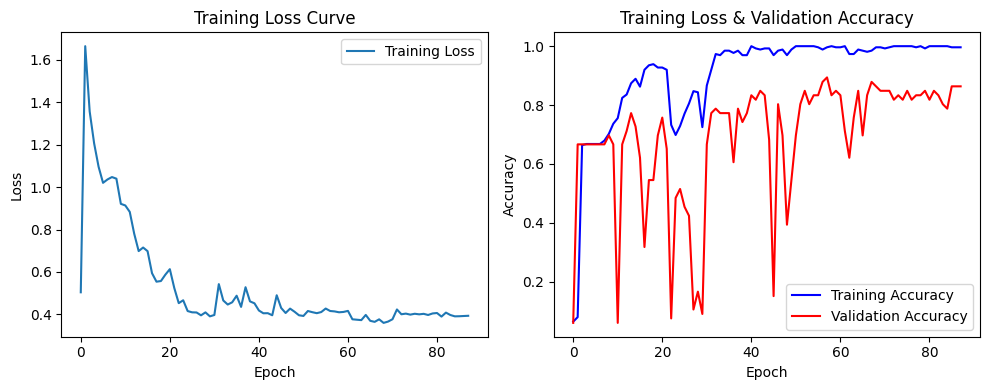

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses_PT, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_PT, label='Training Accuracy', color='blue')
plt.plot(val_accuracies_PT, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_2757843/4238049194.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_PreT.pt"))


預測 000.png → 類別：5



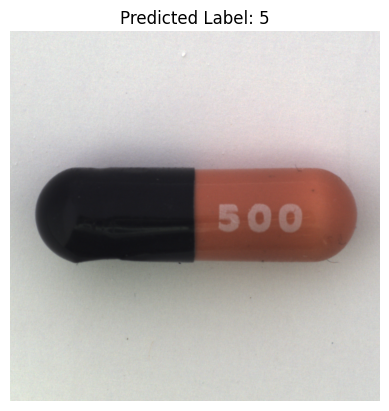

In [49]:
img = Image.open('/mnt/sda1/shuof/DL/HW2/capsule/squeeze/002.png').convert('RGB')
img_tensor = test_transform(img).unsqueeze(0).to(device)

model.load_state_dict(torch.load("best_model_PreT.pt"))
model.eval()
with torch.no_grad():
    pred = model(img_tensor).logits.argmax(1).item()  # 加上 .logits

print(f"預測 000.png → 類別：{pred}\n")

plt.imshow(img)
plt.title(f"Predicted Label: {pred}")
plt.axis('off')
plt.show()

In [ ]:
# ✅ 1. 先建立模型架構（要與 best_model_PreT.pt 訓練時相同）
from torchvision.models import resnet50
import torch.nn as nn

model = resnet50(pretrained=False)
model.fc = nn.Linear(2048, num_classes)  # 這個要對應你的分類數，例如 num_classes = 11
model = model.to(device)

# ✅ 2. 再載入權重
state_dict = torch.load("best_model_PreT.pt")
model.load_state_dict(state_dict)

# ✅ 3. 預測流程（保留原來的程式）
model.eval()
with torch.no_grad():
    pred = model(img_tensor).argmax(1).item()

print(f"預測 → 類別：{pred}")
plt.imshow(img)
plt.title(f"Predicted Label: {pred}")
plt.axis('off')
plt.show()


# 兩個 RestNet 版本比較

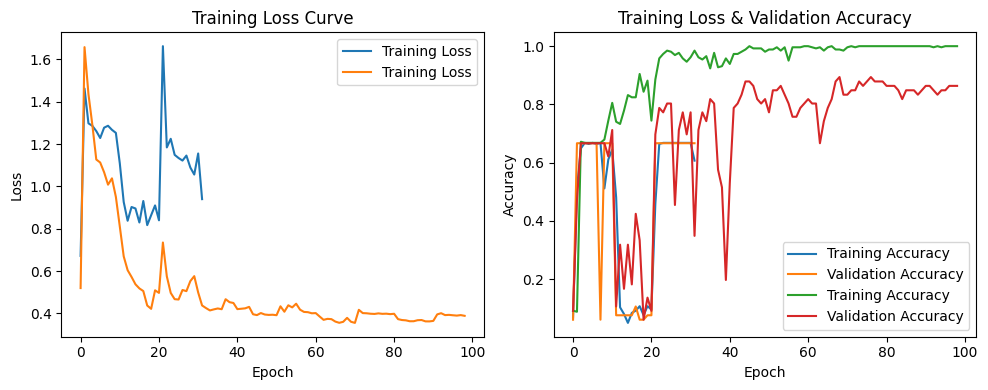

In [ ]:
# 左圖藍線是自建、橘線是預訓練
# 右圖藍橘線是自建、綠紅線是預訓練

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(train_losses_PT, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(train_accuracies_PT, label='Training Accuracy')
plt.plot(val_accuracies_PT, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 其他 Pre-Trained Model
## Vision Transformer (base-sized model)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him.

In [139]:
from transformers import ViTImageProcessor, ViTForImageClassification

# 儲存訓練過程的數據
train_losses_ViT = []
train_accuracies_ViT = []
val_accuracies_ViT = []

best_model_path = 'best_model_ViT.pt'
best_acc = 0
patience = 30

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

old_linear = model.classifier  # 拿到最後一層 Linear
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # 加一層 Dropout
    nn.Linear(old_linear.in_features, num_classes)
)
model = model.to(device)

weights = compute_dynamic_weights(class_counts)

# ----- Loss, Optimizer, Scheduler -----
criterion = FocalLoss(alpha=weights, gamma=2.0, reduction='none') 
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

# ----- 開始訓練 -----
for epoch in range(200):
    model.train()
    
    total_loss = 0
    correct_train, total_train = 0, 0
    class_loss_sum = defaultdict(float)
    class_sample_count = defaultdict(int)

    train_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs).logits # model(imgs)
        per_sample_loss = criterion(outputs, labels)
        loss = per_sample_loss.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_loss_sum[label] += per_sample_loss[i].item()
            class_sample_count[label] += 1

    train_acc = correct_train / total_train
    train_accuracies_ViT.append(train_acc)
    avg_train_loss = total_loss / len(train_loader)
    train_losses_ViT.append(avg_train_loss)

    print(f"\nEpoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")
    
    # ----- 驗證 -----
    model.eval()
    correct, total = 0, 0
    class_val_losses = [0.0 for _ in range(num_classes)]
    class_val_counts = [0 for _ in range(num_classes)]

    val_bar = tqdm(valid_loader, desc=f"[Valid] Epoch {epoch+1}", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits # model(imgs)
            val_loss = F.cross_entropy(outputs, labels, reduction='none')

            for i in range(len(labels)):
                cls = labels[i].item()
                class_val_losses[cls] += val_loss[i].item()
                class_val_counts[cls] += 1

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies_ViT.append(val_acc)
    print(f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")

    # 每10 epoch 顯示類別 loss 和動態調整 class weiights
    if epoch % 10 == 0:
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
        print("[Per-class Training Loss]")
        for c in range(num_classes):
            if class_sample_count[c] > 0:
                avg = class_loss_sum[c] / class_sample_count[c]
                print(f"  Class {c}: Avg Train Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        print("[Per-class Validation Loss]")
        for c in range(num_classes):
            if class_val_counts[c] > 0:
                avg = class_val_losses[c] / class_val_counts[c]
                print(f"  Class {c}: Avg Val Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        # 動態調整 class weights（方式B）
        weights = compute_dynamic_loss_weights(class_val_losses, class_val_counts, class_counts, alpha=0.5).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1, reduction='none')
        print(f"Updated class weights at epoch {epoch+1}: {weights.cpu().numpy()}")

    # Early stopping 判斷
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("=== Accuracy improved, model saved. ===")
    else:
        counter += 1
        print(f"=== No improvement for {counter} epochs. ===")

    if counter >= patience:
        print("=== Early stopping triggered. ===")
        break

    scheduler.step()


Epoch 1 | Training Loss: 0.6012


Training Accuracy: 0.1069 | Validation Accuracy: 0.0606
Current LR: 0.000030
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.4272
  Class 1: Avg Train Loss = 1.8526
  Class 2: Avg Train Loss = 0.0302
  Class 3: Avg Train Loss = 1.6290
  Class 4: Avg Train Loss = 1.4660
  Class 5: Avg Train Loss = 1.5655
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.0450
  Class 1: Avg Val Loss = 1.0355
  Class 2: Avg Val Loss = 3.1045
  Class 3: Avg Val Loss = 1.9114
  Class 4: Avg Val Loss = 1.9674
  Class 5: Avg Val Loss = 1.7078
Updated class weights at epoch 1: [1.0771722 0.84517   0.8495645 1.0960598 1.0573937 1.0746399]
=== Accuracy improved, model saved. ===



Epoch 2 | Training Loss: 1.5969


Training Accuracy: 0.3740 | Validation Accuracy: 0.6667
=== Accuracy improved, model saved. ===



Epoch 3 | Training Loss: 1.3173


Training Accuracy: 0.6679 | Validation Accuracy: 0.6667
=== No improvement for 1 epochs. ===



Epoch 4 | Training Loss: 1.2079


Training Accuracy: 0.6794 | Validation Accuracy: 0.6667
=== No improvement for 2 epochs. ===



Epoch 5 | Training Loss: 1.1851


Training Accuracy: 0.6794 | Validation Accuracy: 0.6667
=== No improvement for 3 epochs. ===



Epoch 6 | Training Loss: 1.1307


Training Accuracy: 0.7137 | Validation Accuracy: 0.6667
=== No improvement for 4 epochs. ===



Epoch 7 | Training Loss: 1.1308


Training Accuracy: 0.7252 | Validation Accuracy: 0.7121
=== Accuracy improved, model saved. ===



Epoch 8 | Training Loss: 1.0436


Training Accuracy: 0.7405 | Validation Accuracy: 0.7273
=== Accuracy improved, model saved. ===



Epoch 9 | Training Loss: 1.0296


Training Accuracy: 0.7519 | Validation Accuracy: 0.7424
=== Accuracy improved, model saved. ===



Epoch 10 | Training Loss: 0.9909


Training Accuracy: 0.7252 | Validation Accuracy: 0.7576
=== Accuracy improved, model saved. ===



Epoch 11 | Training Loss: 1.0269


Training Accuracy: 0.7710 | Validation Accuracy: 0.7424
Current LR: 0.000030
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.3217
  Class 1: Avg Train Loss = 2.1521
  Class 2: Avg Train Loss = 0.5334
  Class 3: Avg Train Loss = 2.6370
  Class 4: Avg Train Loss = 2.0258
  Class 5: Avg Train Loss = 0.6865
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.1520
  Class 1: Avg Val Loss = 1.9581
  Class 2: Avg Val Loss = 0.2409
  Class 3: Avg Val Loss = 1.8361
  Class 4: Avg Val Loss = 2.3582
  Class 5: Avg Val Loss = 0.8954
Updated class weights at epoch 11: [1.2398345  1.2035031  0.13495187 1.1923995  1.305377   0.92393386]
=== No improvement for 1 epochs. ===



Epoch 12 | Training Loss: 0.7904


Training Accuracy: 0.4771 | Validation Accuracy: 0.3788
=== No improvement for 2 epochs. ===



Epoch 13 | Training Loss: 0.7789


Training Accuracy: 0.3931 | Validation Accuracy: 0.2727
=== No improvement for 3 epochs. ===



Epoch 14 | Training Loss: 0.6953


Training Accuracy: 0.6527 | Validation Accuracy: 0.6515
=== No improvement for 4 epochs. ===



Epoch 15 | Training Loss: 0.6642


Training Accuracy: 0.6870 | Validation Accuracy: 0.7121
=== No improvement for 5 epochs. ===



Epoch 16 | Training Loss: 0.6448


Training Accuracy: 0.6947 | Validation Accuracy: 0.5606
=== No improvement for 6 epochs. ===



Epoch 17 | Training Loss: 0.5431


Training Accuracy: 0.8168 | Validation Accuracy: 0.4848
=== No improvement for 7 epochs. ===



Epoch 18 | Training Loss: 0.6122


Training Accuracy: 0.7557 | Validation Accuracy: 0.6364
=== No improvement for 8 epochs. ===



Epoch 19 | Training Loss: 0.6022


Training Accuracy: 0.6298 | Validation Accuracy: 0.7121
=== No improvement for 9 epochs. ===



Epoch 20 | Training Loss: 0.5448


Training Accuracy: 0.8206 | Validation Accuracy: 0.7879
=== Accuracy improved, model saved. ===



Epoch 21 | Training Loss: 0.5181


Training Accuracy: 0.8206 | Validation Accuracy: 0.6970
Current LR: 0.000028
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.9534
  Class 1: Avg Train Loss = 0.8817
  Class 2: Avg Train Loss = 0.3472
  Class 3: Avg Train Loss = 1.1201
  Class 4: Avg Train Loss = 0.9947
  Class 5: Avg Train Loss = 0.4720
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.0614
  Class 1: Avg Val Loss = 0.9020
  Class 2: Avg Val Loss = 1.0283
  Class 3: Avg Val Loss = 1.5159
  Class 4: Avg Val Loss = 0.9474
  Class 5: Avg Val Loss = 0.2813
Updated class weights at epoch 21: [1.1111069  1.0530078  0.5961674  1.4017131  1.0514767  0.78652805]
=== No improvement for 1 epochs. ===



Epoch 22 | Training Loss: 0.6315


Training Accuracy: 0.9160 | Validation Accuracy: 0.6970
=== No improvement for 2 epochs. ===



Epoch 23 | Training Loss: 0.7972


Training Accuracy: 0.8435 | Validation Accuracy: 0.8333
=== Accuracy improved, model saved. ===



Epoch 24 | Training Loss: 0.6319


Training Accuracy: 0.9237 | Validation Accuracy: 0.7576
=== No improvement for 1 epochs. ===



Epoch 25 | Training Loss: 0.5705


Training Accuracy: 0.9160 | Validation Accuracy: 0.7879
=== No improvement for 2 epochs. ===



Epoch 26 | Training Loss: 0.5510


Training Accuracy: 0.9389 | Validation Accuracy: 0.8182
=== No improvement for 3 epochs. ===



Epoch 27 | Training Loss: 0.5678


Training Accuracy: 0.9695 | Validation Accuracy: 0.8030
=== No improvement for 4 epochs. ===



Epoch 28 | Training Loss: 0.5219


Training Accuracy: 0.9504 | Validation Accuracy: 0.8030
=== No improvement for 5 epochs. ===



Epoch 29 | Training Loss: 0.5285


Training Accuracy: 0.9542 | Validation Accuracy: 0.7879
=== No improvement for 6 epochs. ===



Epoch 30 | Training Loss: 0.5419


Training Accuracy: 0.9466 | Validation Accuracy: 0.7879
=== No improvement for 7 epochs. ===



Epoch 31 | Training Loss: 0.5000


Training Accuracy: 0.9733 | Validation Accuracy: 0.8182
Current LR: 0.000026
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4972
  Class 1: Avg Train Loss = 0.8275
  Class 2: Avg Train Loss = 0.4371
  Class 3: Avg Train Loss = 0.8854
  Class 4: Avg Train Loss = 0.5826
  Class 5: Avg Train Loss = 0.4519
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.8122
  Class 1: Avg Val Loss = 1.4005
  Class 2: Avg Val Loss = 0.4386
  Class 3: Avg Val Loss = 1.2616
  Class 4: Avg Val Loss = 1.2944
  Class 5: Avg Val Loss = 0.3182
Updated class weights at epoch 31: [1.3891406  1.2251207  0.26004076 1.188948   1.1510752  0.78567475]
=== No improvement for 8 epochs. ===



Epoch 32 | Training Loss: 0.4385


Training Accuracy: 0.9733 | Validation Accuracy: 0.8030
=== No improvement for 9 epochs. ===



Epoch 33 | Training Loss: 0.4244


Training Accuracy: 0.9733 | Validation Accuracy: 0.8333
=== No improvement for 10 epochs. ===



Epoch 34 | Training Loss: 0.4442


Training Accuracy: 0.9580 | Validation Accuracy: 0.7879
=== No improvement for 11 epochs. ===



Epoch 35 | Training Loss: 0.4172


Training Accuracy: 0.9771 | Validation Accuracy: 0.8485
=== Accuracy improved, model saved. ===



Epoch 36 | Training Loss: 0.4387


Training Accuracy: 0.9656 | Validation Accuracy: 0.8636
=== Accuracy improved, model saved. ===



Epoch 37 | Training Loss: 0.4347


Training Accuracy: 0.9847 | Validation Accuracy: 0.7727
=== No improvement for 1 epochs. ===



Epoch 38 | Training Loss: 0.4070


Training Accuracy: 0.9695 | Validation Accuracy: 0.8485
=== No improvement for 2 epochs. ===



Epoch 39 | Training Loss: 0.4438


Training Accuracy: 0.9695 | Validation Accuracy: 0.8030
=== No improvement for 3 epochs. ===



Epoch 40 | Training Loss: 0.4266


Training Accuracy: 0.9695 | Validation Accuracy: 0.8182
=== No improvement for 4 epochs. ===



Epoch 41 | Training Loss: 0.4350


Training Accuracy: 0.9809 | Validation Accuracy: 0.8030
Current LR: 0.000023
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.6468
  Class 1: Avg Train Loss = 0.4814
  Class 2: Avg Train Loss = 0.3645
  Class 3: Avg Train Loss = 0.7977
  Class 4: Avg Train Loss = 0.5564
  Class 5: Avg Train Loss = 0.4380
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.0596
  Class 1: Avg Val Loss = 1.0438
  Class 2: Avg Val Loss = 0.6008
  Class 3: Avg Val Loss = 0.7170
  Class 4: Avg Val Loss = 1.2071
  Class 5: Avg Val Loss = 0.5156
Updated class weights at epoch 41: [1.5616907  1.0909389  0.35174996 0.9590516  1.1453911  0.8911776 ]
=== No improvement for 5 epochs. ===



Epoch 42 | Training Loss: 0.4267


Training Accuracy: 0.9885 | Validation Accuracy: 0.8030
=== No improvement for 6 epochs. ===



Epoch 43 | Training Loss: 0.4189


Training Accuracy: 0.9885 | Validation Accuracy: 0.8182
=== No improvement for 7 epochs. ===



Epoch 44 | Training Loss: 0.4139


Training Accuracy: 0.9847 | Validation Accuracy: 0.8636
=== No improvement for 8 epochs. ===



Epoch 45 | Training Loss: 0.4662


Training Accuracy: 0.9885 | Validation Accuracy: 0.8182
=== No improvement for 9 epochs. ===



Epoch 46 | Training Loss: 0.4348


Training Accuracy: 0.9695 | Validation Accuracy: 0.8636
=== No improvement for 10 epochs. ===



Epoch 47 | Training Loss: 0.4476


Training Accuracy: 0.9771 | Validation Accuracy: 0.8788
=== Accuracy improved, model saved. ===



Epoch 48 | Training Loss: 0.4580


Training Accuracy: 0.9504 | Validation Accuracy: 0.8636
=== No improvement for 1 epochs. ===



Epoch 49 | Training Loss: 0.4311


Training Accuracy: 0.9847 | Validation Accuracy: 0.8485
=== No improvement for 2 epochs. ===



Epoch 50 | Training Loss: 0.4176


Training Accuracy: 0.9924 | Validation Accuracy: 0.8485
=== No improvement for 3 epochs. ===



Epoch 51 | Training Loss: 0.4190


Training Accuracy: 0.9809 | Validation Accuracy: 0.8182
Current LR: 0.000020
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4260
  Class 1: Avg Train Loss = 0.4388
  Class 2: Avg Train Loss = 0.3882
  Class 3: Avg Train Loss = 0.5532
  Class 4: Avg Train Loss = 0.5545
  Class 5: Avg Train Loss = 0.4264
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.9459
  Class 1: Avg Val Loss = 1.0045
  Class 2: Avg Val Loss = 0.4254
  Class 3: Avg Val Loss = 0.9244
  Class 4: Avg Val Loss = 0.9871
  Class 5: Avg Val Loss = 0.4082
Updated class weights at epoch 51: [1.5809741  1.1103472  0.28247246 1.0958549  1.075958   0.8543934 ]
=== No improvement for 4 epochs. ===



Epoch 52 | Training Loss: 0.4031


Training Accuracy: 0.9885 | Validation Accuracy: 0.8485
=== No improvement for 5 epochs. ===



Epoch 53 | Training Loss: 0.4135


Training Accuracy: 0.9924 | Validation Accuracy: 0.8333
=== No improvement for 6 epochs. ===



Epoch 54 | Training Loss: 0.4006


Training Accuracy: 0.9847 | Validation Accuracy: 0.8333
=== No improvement for 7 epochs. ===



Epoch 55 | Training Loss: 0.3982


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
=== No improvement for 8 epochs. ===



Epoch 56 | Training Loss: 0.3969


Training Accuracy: 0.9924 | Validation Accuracy: 0.8485
=== No improvement for 9 epochs. ===



Epoch 57 | Training Loss: 0.3927


Training Accuracy: 1.0000 | Validation Accuracy: 0.8333
=== No improvement for 10 epochs. ===



Epoch 58 | Training Loss: 0.3932


Training Accuracy: 0.9962 | Validation Accuracy: 0.8636
=== No improvement for 11 epochs. ===



Epoch 59 | Training Loss: 0.4194


Training Accuracy: 0.9847 | Validation Accuracy: 0.8636
=== No improvement for 12 epochs. ===



Epoch 60 | Training Loss: 0.4063


Training Accuracy: 0.9618 | Validation Accuracy: 0.8636
=== No improvement for 13 epochs. ===



Epoch 61 | Training Loss: 0.4054


Training Accuracy: 0.9924 | Validation Accuracy: 0.8636
Current LR: 0.000017
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.6120
  Class 1: Avg Train Loss = 0.4269
  Class 2: Avg Train Loss = 0.3683
  Class 3: Avg Train Loss = 0.4644
  Class 4: Avg Train Loss = 0.4718
  Class 5: Avg Train Loss = 0.4297
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.2932
  Class 1: Avg Val Loss = 0.9354
  Class 2: Avg Val Loss = 0.3535
  Class 3: Avg Val Loss = 0.9183
  Class 4: Avg Val Loss = 1.0738
  Class 5: Avg Val Loss = 0.5373
Updated class weights at epoch 61: [1.3149769 1.1302539 0.2658402 1.1479144 1.1862495 0.9547651]
=== No improvement for 14 epochs. ===



Epoch 62 | Training Loss: 0.4179


Training Accuracy: 0.9847 | Validation Accuracy: 0.8485
=== No improvement for 15 epochs. ===



Epoch 63 | Training Loss: 0.4041


Training Accuracy: 0.9809 | Validation Accuracy: 0.8788
=== No improvement for 16 epochs. ===



Epoch 64 | Training Loss: 0.3958


Training Accuracy: 0.9885 | Validation Accuracy: 0.8788
=== No improvement for 17 epochs. ===



Epoch 65 | Training Loss: 0.3938


Training Accuracy: 0.9962 | Validation Accuracy: 0.8636
=== No improvement for 18 epochs. ===



Epoch 66 | Training Loss: 0.3926


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
=== No improvement for 19 epochs. ===



Epoch 67 | Training Loss: 0.4009


Training Accuracy: 0.9885 | Validation Accuracy: 0.8636
=== No improvement for 20 epochs. ===



Epoch 68 | Training Loss: 0.3994


Training Accuracy: 0.9809 | Validation Accuracy: 0.8485
=== No improvement for 21 epochs. ===



Epoch 69 | Training Loss: 0.3954


Training Accuracy: 0.9962 | Validation Accuracy: 0.8939
=== Accuracy improved, model saved. ===



Epoch 70 | Training Loss: 0.3948


Training Accuracy: 0.9962 | Validation Accuracy: 0.8788
=== No improvement for 1 epochs. ===



Epoch 71 | Training Loss: 0.3894


Training Accuracy: 1.0000 | Validation Accuracy: 0.8636
Current LR: 0.000014
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4259
  Class 1: Avg Train Loss = 0.4342
  Class 2: Avg Train Loss = 0.3640
  Class 3: Avg Train Loss = 0.4376
  Class 4: Avg Train Loss = 0.4596
  Class 5: Avg Train Loss = 0.4276
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.0117
  Class 1: Avg Val Loss = 0.9899
  Class 2: Avg Val Loss = 0.4321
  Class 3: Avg Val Loss = 0.8608
  Class 4: Avg Val Loss = 1.0891
  Class 5: Avg Val Loss = 0.2709
Updated class weights at epoch 71: [1.6233106 1.1064593 0.2876454 1.0656459 1.1338229 0.7831158]
=== No improvement for 2 epochs. ===



Epoch 72 | Training Loss: 0.3952


Training Accuracy: 0.9962 | Validation Accuracy: 0.8636
=== No improvement for 3 epochs. ===



Epoch 73 | Training Loss: 0.3927


Training Accuracy: 1.0000 | Validation Accuracy: 0.8636
=== No improvement for 4 epochs. ===



Epoch 74 | Training Loss: 0.3876


Training Accuracy: 1.0000 | Validation Accuracy: 0.8939
=== No improvement for 5 epochs. ===



Epoch 75 | Training Loss: 0.3898


Training Accuracy: 0.9924 | Validation Accuracy: 0.8939
=== No improvement for 6 epochs. ===



Epoch 76 | Training Loss: 0.3855


Training Accuracy: 1.0000 | Validation Accuracy: 0.8788
=== No improvement for 7 epochs. ===



Epoch 77 | Training Loss: 0.3879


Training Accuracy: 1.0000 | Validation Accuracy: 0.8788
=== No improvement for 8 epochs. ===



Epoch 78 | Training Loss: 0.3915


Training Accuracy: 0.9962 | Validation Accuracy: 0.8788
=== No improvement for 9 epochs. ===



Epoch 79 | Training Loss: 0.3900


Training Accuracy: 0.9924 | Validation Accuracy: 0.8485
=== No improvement for 10 epochs. ===



Epoch 80 | Training Loss: 0.3969


Training Accuracy: 0.9885 | Validation Accuracy: 0.8636
=== No improvement for 11 epochs. ===



Epoch 81 | Training Loss: 0.4037


Training Accuracy: 0.9885 | Validation Accuracy: 0.8788
Current LR: 0.000012
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4251
  Class 1: Avg Train Loss = 0.4283
  Class 2: Avg Train Loss = 0.3740
  Class 3: Avg Train Loss = 0.4253
  Class 4: Avg Train Loss = 0.5520
  Class 5: Avg Train Loss = 0.4202
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.6107
  Class 1: Avg Val Loss = 1.0281
  Class 2: Avg Val Loss = 0.2837
  Class 3: Avg Val Loss = 0.8422
  Class 4: Avg Val Loss = 1.9395
  Class 5: Avg Val Loss = 0.4168
Updated class weights at epoch 81: [1.3454419  1.0851748  0.19742201 1.0217339  1.5065731  0.8436543 ]
=== No improvement for 12 epochs. ===



Epoch 82 | Training Loss: 0.3956


Training Accuracy: 0.9924 | Validation Accuracy: 0.8788
=== No improvement for 13 epochs. ===



Epoch 83 | Training Loss: 0.3747


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
=== No improvement for 14 epochs. ===



Epoch 84 | Training Loss: 0.3800


Training Accuracy: 0.9771 | Validation Accuracy: 0.8788
=== No improvement for 15 epochs. ===



Epoch 85 | Training Loss: 0.3986


Training Accuracy: 0.9847 | Validation Accuracy: 0.7879
=== No improvement for 16 epochs. ===



Epoch 86 | Training Loss: 0.3976


Training Accuracy: 0.9885 | Validation Accuracy: 0.8485
=== No improvement for 17 epochs. ===



Epoch 87 | Training Loss: 0.3854


Training Accuracy: 0.9809 | Validation Accuracy: 0.8485
=== No improvement for 18 epochs. ===



Epoch 88 | Training Loss: 0.3739


Training Accuracy: 1.0000 | Validation Accuracy: 0.8636
=== No improvement for 19 epochs. ===



Epoch 89 | Training Loss: 0.3661


Training Accuracy: 1.0000 | Validation Accuracy: 0.8333
=== No improvement for 20 epochs. ===



Epoch 90 | Training Loss: 0.3725


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
=== No improvement for 21 epochs. ===



Epoch 91 | Training Loss: 0.3759


Training Accuracy: 0.9885 | Validation Accuracy: 0.8182
Current LR: 0.000010
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.4320
  Class 1: Avg Train Loss = 0.4303
  Class 2: Avg Train Loss = 0.3450
  Class 3: Avg Train Loss = 0.4543
  Class 4: Avg Train Loss = 0.4469
  Class 5: Avg Train Loss = 0.4201
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.7880
  Class 1: Avg Val Loss = 1.0331
  Class 2: Avg Val Loss = 0.5847
  Class 3: Avg Val Loss = 0.8603
  Class 4: Avg Val Loss = 0.9209
  Class 5: Avg Val Loss = 0.4404
Updated class weights at epoch 91: [1.5091951 1.1320388 0.3701078 1.0675496 1.046914  0.8741947]
=== No improvement for 22 epochs. ===



Epoch 92 | Training Loss: 0.4122


Training Accuracy: 0.9962 | Validation Accuracy: 0.8333
=== No improvement for 23 epochs. ===



Epoch 93 | Training Loss: 0.4015


Training Accuracy: 1.0000 | Validation Accuracy: 0.8485
=== No improvement for 24 epochs. ===



Epoch 94 | Training Loss: 0.4126


Training Accuracy: 0.9962 | Validation Accuracy: 0.8485
=== No improvement for 25 epochs. ===



Epoch 95 | Training Loss: 0.3981


Training Accuracy: 1.0000 | Validation Accuracy: 0.8636
=== No improvement for 26 epochs. ===



Epoch 96 | Training Loss: 0.4006


Training Accuracy: 0.9962 | Validation Accuracy: 0.8030
=== No improvement for 27 epochs. ===



Epoch 97 | Training Loss: 0.4033


Training Accuracy: 0.9962 | Validation Accuracy: 0.8485
=== No improvement for 28 epochs. ===



Epoch 98 | Training Loss: 0.3987


Training Accuracy: 1.0000 | Validation Accuracy: 0.8485
=== No improvement for 29 epochs. ===



Epoch 99 | Training Loss: 0.4003


Training Accuracy: 1.0000 | Validation Accuracy: 0.8485
=== No improvement for 30 epochs. ===
=== Early stopping triggered. ===


#### ViT 訓練過程紀錄

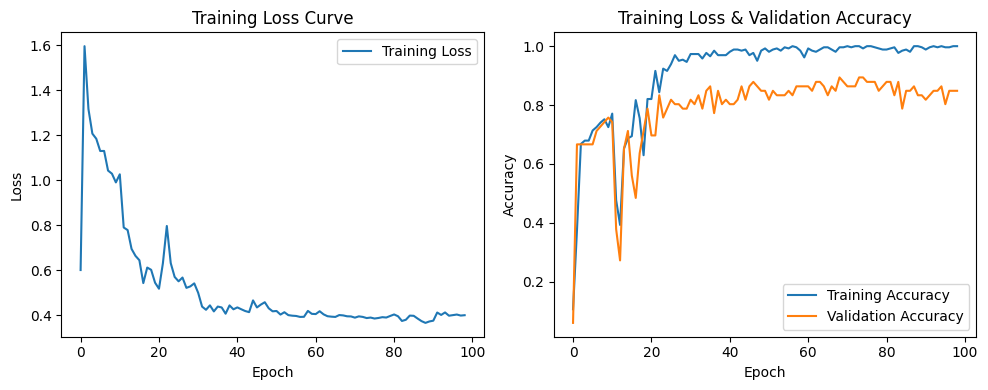

In [140]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses_ViT, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_ViT, label='Training Accuracy')
plt.plot(val_accuracies_ViT, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Pre-Trained RestNet V.S. Pre-Trained ViT

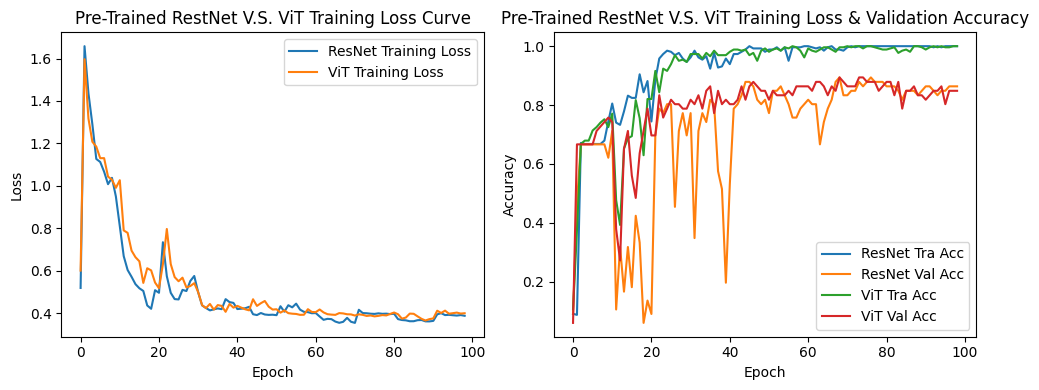

In [141]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
#plt.plot(train_losses, label='Training Loss')
plt.plot(train_losses_PT, label='ResNet Training Loss')
plt.plot(train_losses_ViT, label='ViT Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-Trained RestNet V.S. ViT Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(train_accuracies, label='Training Accuracy')
#plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(train_accuracies_PT, label='ResNet Tra Acc')
plt.plot(val_accuracies_PT, label='ResNet Val Acc')
plt.plot(train_accuracies_ViT, label='ViT Tra Acc')
plt.plot(val_accuracies_ViT, label='ViT Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Pre-Trained RestNet V.S. ViT Training Loss & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()